# Considerations

#### What is the Airbnb business model?

- Marketplace: connect people offering homestays with people looking for homestays.
                  
- Gross Revenue = (Fee * Users) - CAC

# Libraries

In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.gridspec as gridspec
import tensorflow as tf

from IPython.display import Image
from matplotlib import pyplot as plt
from keras import models as ml
from keras import layers as l
from scikitplot import metrics as mt
from scipy import stats as ss
from pandas_profiling import ProfileReport
from category_encoders import TargetEncoder 
from boruta import BorutaPy

from imblearn import under_sampling as us
from imblearn import over_sampling as oversamp
from imblearn import combine as c

from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics as m
from sklearn.ensemble import RandomForestRegressor

## Helper Functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

## Loading Data

In [3]:
data_raw_age_gender = pd.read_csv("datasets/age_gender_bkts.csv", low_memory=False)
data_raw_age_gender

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0
...,...,...,...,...,...
415,95-99,US,male,115.0,2015.0
416,90-94,US,male,541.0,2015.0
417,15-19,US,female,10570.0,2015.0
418,85-89,US,male,1441.0,2015.0


In [4]:
data_raw_countries = pd.read_csv("datasets/countries.csv", low_memory=False)
data_raw_countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [5]:
data_raw_sample_submission = pd.read_csv("datasets/sample_submission_NDF.csv", low_memory=False)
data_raw_sample_submission

,id,country
0,5uwns89zht,NDF
1,jtl0dijy2j,NDF
2,xx0ulgorjt,NDF
3,6c6puo6ix0,NDF
4,czqhjk3yfe,NDF
...,...,...
62091,cv0na2lf5a,NDF
62092,zp8xfonng8,NDF
62093,fa6260ziny,NDF
62094,87k0fy4ugm,NDF


In [6]:
df_sessions = pd.read_csv("datasets/sessions.csv", low_memory=True)
df_sessions

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
...,...,...,...,...,...,...
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556.0
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624.0
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125.0
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624.0


In [7]:
data_raw_test_users = pd.read_csv("datasets/test_users.csv", low_memory=False)
data_raw_test_users

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62091,cv0na2lf5a,2014-09-30,20140930235232,NaN,-unknown-,31.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE
62092,zp8xfonng8,2014-09-30,20140930235306,NaN,-unknown-,NaN,basic,23,ko,direct,direct,untracked,Android,Android Phone,-unknown-
62093,fa6260ziny,2014-09-30,20140930235408,NaN,-unknown-,NaN,basic,0,de,direct,direct,linked,Web,Windows Desktop,Firefox
62094,87k0fy4ugm,2014-09-30,20140930235430,NaN,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari


In [8]:
data_raw_train_users = pd.read_csv("datasets/train_users_2.csv", low_memory=False)
data_raw_train_users

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


#### Could we merge sesions with train_users?

Sessions and train_users are our main tables. We are going to use both of them in this project. Yet, we cannot merge these tables now because they have different granularity: 

**(1)** train_user is user-level (informations are: one user per row). 

**(2)** sessions is secs_elapsed-level (informations are related to action, action_type, action_detail, device_type and secs_elapse - and this one is the highest level).

To merge the two tables, we need to encoding the columns from sessions. 

In [9]:
# train user
data_raw_train_users[data_raw_train_users["id"] == "nw9fwlyb5f"]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
213450,nw9fwlyb5f,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF


In [10]:
# sessions
df_sessions[df_sessions["user_id"] == "nw9fwlyb5f"].head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
5555239,nw9fwlyb5f,show,view,user_profile,iPhone,9310.0
5555240,nw9fwlyb5f,show,view,p3,iPhone,33.0
5555241,nw9fwlyb5f,reviews,data,listing_reviews,iPhone,8.0
5555242,nw9fwlyb5f,campaigns,NaN,NaN,iPhone,41983.0
5555243,nw9fwlyb5f,click,click,book_it,iPhone,58491.0


In [11]:
# sessions
df_sessions[(df_sessions["user_id"] == "nw9fwlyb5f") & (df_sessions["action"] == "reviews")].head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
5555241,nw9fwlyb5f,reviews,data,listing_reviews,iPhone,8.0
5555269,nw9fwlyb5f,reviews,data,listing_reviews,iPhone,11.0


# 1. Data Description

In [12]:
df1 = data_raw_train_users.copy()

### Data fields meaning

- id: user id.

- date_account_created: the date of account creation.

- timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or - date_first_booking because a user can search before signing up.

- date_first_booking: date of first booking.

- gender.

- age.

- signup_method.

- signup_flow: the page a user came to signup up from.

- language: international language preference.

- affiliate_channel: what kind of paid marketing.

- affiliate_provider: where the marketing is e.g. google, craigslist, other.

- first_affiliate_tracked: whats the first marketing the user interacted with before the signing up.

- signup_app.

- first_device_type.

- first_browser.

- country_destination: this is the target variable you are to predict.

## 1.1. Data Dimensions

In [13]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 213451
Number of cols: 16


In [14]:
print("Number of rows: {}".format(df_sessions.shape[0]))
print("Number of cols: {}".format(df_sessions.shape[1]))

Number of rows: 10567737
Number of cols: 6


## 1.2. Data Types

In [15]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [16]:
df1.sample(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
191603,o0bk1uehu7,2014-05-19,20140519160242,2014-05-19,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Mac Desktop,Chrome,IT
118220,d7pen73jjp,2013-10-20,20131020170932,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Mac Desktop,Safari,NDF
23920,ndzh3frwjd,2012-05-11,20120511230007,NaN,MALE,39.0,facebook,0,en,other,craigslist,tracked-other,Web,Mac Desktop,Safari,NDF


In [17]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

In [18]:
df_sessions.sample(3)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
38595,3hy9yi6hi8,search_results,click,view_search_results,Mac Desktop,877.0
4114996,9hxjodf47q,index,view,view_search_results,Mac Desktop,1551.0
3303589,pz5hpjrutr,index,view,view_search_results,Mac Desktop,2069.0


## 1.3. NA Check

In [19]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [20]:
df1.isna().sum()/len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [21]:
df_sessions.isna().sum()/len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

The percentage of NA values of date_first_booking is very high. We must check the proportion of NA values for this column related to our classes:

In [22]:
aux = df1[df1["date_first_booking"].isna()]
aux["country_destination"].value_counts(normalize=True)

NDF    1.0
Name: country_destination, dtype: float64

- All NA values from date_first_booking class are from country_destinarion = NDF. 
- People who do not have a destination country does not have date first booking.
- A solution is to replace this Na values with the maximum date of our dataset. 

Similarly, let's analyze the column age:

In [23]:
aux = df1[df1["age"].isna()]
aux["country_destination"].value_counts(normalize=True)

NDF      0.768428
US       0.156529
other    0.028617
FR       0.014888
IT       0.009081
GB       0.006251
ES       0.006171
CA       0.003989
DE       0.002387
NL       0.001818
AU       0.001171
PT       0.000671
Name: country_destination, dtype: float64

We must see how the data distribution is. If our distribution is close to a normal one, we must fill NA values with the average age. As we may see below, we may do this treatment for column age. 

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

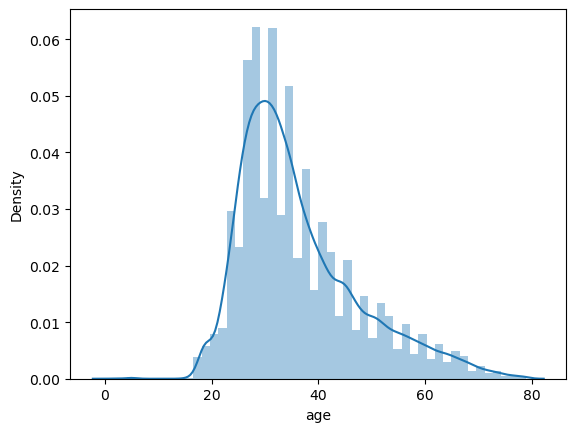

In [24]:
# assumption to see the chart: low incidence of people using Airbnb older than 80 years
sns.distplot(df1[df1["age"] < 80]["age"])

The column first_affiliate_tracked is a categorical one. Replace NA values for this column with any other string may generate a high biased model. As we have only 2.8% of NA values from this column, we may remove all NA values. 

**Suggestion:** In case we had a categorical feature, but with a high percentage of NA values, we could collect more data instead of removing all NA values from that column.

In [25]:
df1["first_affiliate_tracked"].unique()

array(['untracked', 'omg', nan, 'linked', 'tracked-other', 'product',
       'marketing', 'local ops'], dtype=object)

## 1.4. Removing NA

**First cycle:** As we want to deliver a solution as faster as possible, we will remove all NA values in this cycle. However, we may treat NA values using a different technique as next steps.

**Second cycle:** We face some problems by removing NA values.

- Loss of relevant information from columns.
- Data volume decrase to train models.

There are thre manners to remove NA values from our dataset: (1) Business, (2) Statistical and (3) Machine Learning. For further details, check my portfolio project named **Rossmann Store Sales**. 

In [26]:
# ========== User =================

# date_first_booking
date_first_booking_max = pd.to_datetime( df1['date_first_booking'] ).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age
df1_sample = df1[(df1['age'] > 15) & (df1['age'] < 122)]
avg_age = np.round(df1_sample['age'].mean(), 0)
df1['age'] = df1['age'].fillna(avg_age)

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ========== Sessions ==============

# user_id - 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]

# action_type - 11% (total rows amount: more than 10 millions)
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_detail - 11% (total rows amount: more than 10 millions)
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

## 1.5. Change Data Type

In [27]:
# date_account_created
df1["date_account_created"] = pd.to_datetime(df1["date_account_created"])

# timestamp_first_active
df1["timestamp_first_active"] = pd.to_datetime(df1["timestamp_first_active"], format="%Y%m%d%H%M%S")

# date_first_booking
df1["date_first_booking"] = pd.to_datetime(df1["date_first_booking"])

# age
df1["age"] = df1["age"].astype(int)

In [28]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.6. Check Balanced Data

In [29]:
df1["country_destination"].value_counts()

NDF      120216
US        61067
other      9981
FR         4899
IT         2791
GB         2295
ES         2213
CA         1391
DE         1041
NL          751
AU          527
PT          214
Name: country_destination, dtype: int64

In [30]:
df1["country_destination"].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

- This is a multi-class (many types for the target variable) and very unbalanced (29% of data only for US, for instance). This is a very complex classification problem. 

## 1.7. Descriptive Statistics

This section is to find inconsistencies, anomalies and also the main characteristics of our data.

In [31]:
# Users
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes = df1.select_dtypes(include=['datetime64[ns]'])

# Sessions
num_attributes_sessions = df_sessions.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions = df_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.7.1. Numerical attributes - Users

In [32]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenar
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,1.0,2014.0,2013.0,44.325128,37.0,118.575595,16.392840,268.929431
1,signup_flow,0.0,25.0,25.0,3.151490,0.0,7.543915,2.287158,3.567794


- We have maximum age as 2014. This is probably wrong.
- As median is less than mean, we have a left skew: positive skewness. 
- Since age has a 269 value for kurtosis, we have a very high peak.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


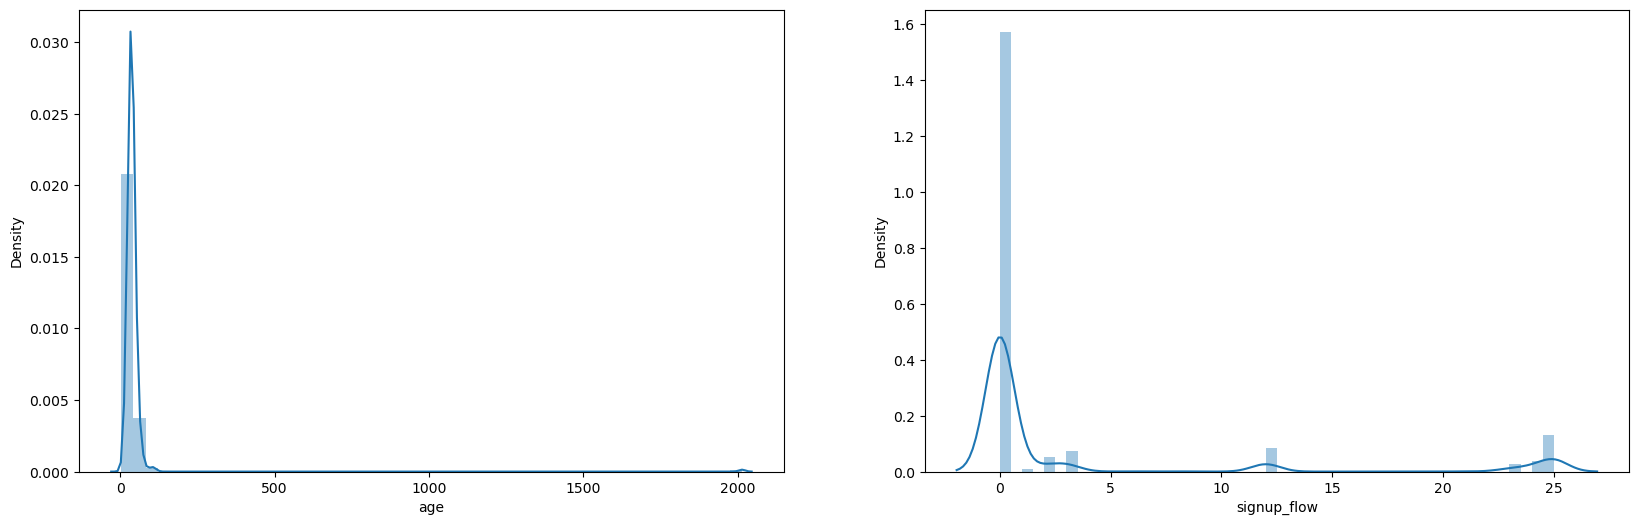

In [33]:
plt.figure(figsize = (20,6))

plt.subplot(121)
sns.distplot(df1["age"])

plt.subplot(122)
sns.distplot(df1["signup_flow"])

plt.subplots_adjust(wspace = 0.2)

We may have lower ages ( <= 2 years old, for instance) in our dataset because they are children accompanied by parents. Yet, we may not have ages higher than 122, since this age is for the oldest person who ever lived on Earth. Thus, these values will be treated as outliers.

### 1.7.2. Numerical Attributes - Sessions

In [34]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame(num_attributes_sessions.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes_sessions.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes_sessions.apply(np.std)).T
d2 = pd.DataFrame(num_attributes_sessions.apply(min)).T
d3 = pd.DataFrame(num_attributes_sessions.apply(max)).T
d4 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis())).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='secs_elapsed', ylabel='Density'>

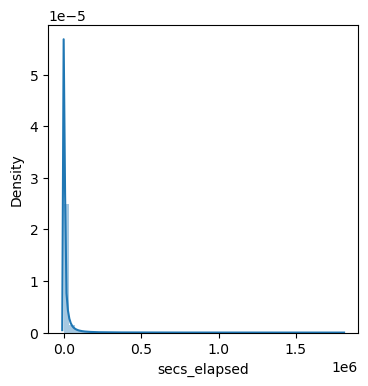

In [35]:
plt.figure(figsize =(4,4))

sns.distplot(df_sessions["secs_elapsed"])

- secs_elpased is the time a user stays on webpage. A value equals zero is not realistic. 
- A maximum value of 1799977.0 seconds is either not realistic, because it represents around 208 days.

### 1.7.3. Categorical Attributes - Users

In [36]:
cat_attributes.apply(lambda x: x.unique().shape[0])

id                         207386
gender                          4
signup_method                   3
language                       25
affiliate_channel               8
affiliate_provider             18
first_affiliate_tracked         7
signup_app                      4
first_device_type               9
first_browser                  52
country_destination            12
dtype: int64

In [37]:
cat_attributes.drop(columns="id").apply(lambda x: x.unique())

gender                                      [-unknown-, MALE, FEMALE, OTHER]
signup_method                                      [facebook, basic, google]
language                   [en, fr, de, es, pt, zh, ko, ja, it, ru, pl, e...
affiliate_channel          [direct, seo, other, sem-non-brand, content, s...
affiliate_provider         [direct, google, other, craigslist, facebook, ...
first_affiliate_tracked    [untracked, omg, linked, tracked-other, produc...
signup_app                                        [Web, Moweb, iOS, Android]
first_device_type          [Mac Desktop, Windows Desktop, iPhone, Other/U...
first_browser              [Chrome, IE, Firefox, Safari, -unknown-, Mobil...
country_destination        [NDF, US, other, CA, FR, ES, GB, IT, PT, NL, D...
dtype: object

In [38]:
cat_attributes.drop("id", axis=1).describe().T

,count,unique,top,freq
gender,207386,4,-unknown-,91783
signup_method,207386,3,basic,148297
language,207386,25,en,200415
affiliate_channel,207386,8,direct,134179
affiliate_provider,207386,18,direct,133935
first_affiliate_tracked,207386,7,untracked,109232
signup_app,207386,4,Web,178334
first_device_type,207386,9,Mac Desktop,89600
first_browser,207386,52,Chrome,63845
country_destination,207386,12,NDF,120216


- Some features have a higher number of unique values. This makes one hot encoding very inappropriate. 
- If there are correlation between these categorical variables, we may remove some of them.

### 1.7.4. Categorical Attributes - Sessions

In [39]:
cat_attributes_sessions.apply(lambda x: x.unique().shape[0])

user_id          133878
action              347
action_type          10
action_detail       155
device_type          14
dtype: int64

In [40]:
cat_attributes_sessions.drop(columns="user_id").apply(lambda x: x.unique())

action           [search_results, personalize, index, similar_l...
action_type      [click, data, view, submit, -unknown-, booking...
action_detail    [view_search_results, wishlist_content_update,...
device_type      [Windows Desktop, -unknown-, Mac Desktop, Andr...
dtype: object

In [41]:
cat_attributes_sessions.drop("user_id", axis=1).describe().T

,count,unique,top,freq
action,9213930,347,show,2178382
action_type,9213930,10,view,3545621
action_detail,9213930,155,view_search_results,1770931
device_type,9213930,14,Mac Desktop,3019523


### 1.7.5. Correlation Matrix - Users

If there are correlation between categorical variables, we may remove some of them. To evaluate correlation between categorical variables, we use Cramer's V method. 

In [42]:
cat_attributes_list = cat_attributes.drop('id', axis=1).columns.tolist()

corr_dict = {}
for i in range( len (cat_attributes_list)):
    corr_list = []
    for j in range(len( cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ref] = corr_list

<AxesSubplot:>

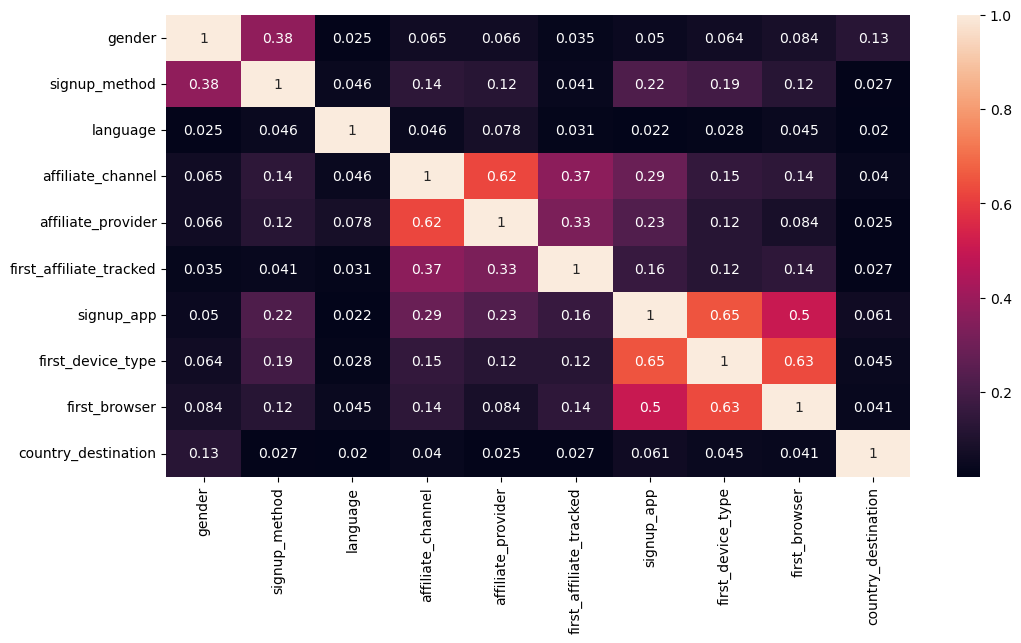

In [43]:
plt.figure(figsize =(12,6))

d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

Score for Cramer's V from 0 to 1. Thus, very correlated features are those higher than 60%:

1. first_device_type and signup_app: 0.65.
2. first_browser and first_device_type: 0.63. 
3. affiliate_provider and affiliate_channel: 0.62.

Choice:

1. signup_app: 4 unique values.
2. first_device_type: 9 unique values.
3. affiliate_channel: 8 unique values.
4. signup_app: 4 unique values. 

The columns that we may remove are: first_device_type, first_browser and affiliate_provider. 

### 1.7.6. Correlation Matrix - Sessions

In [44]:
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}
for i in range( len ( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ref] = corr_list

<AxesSubplot:>

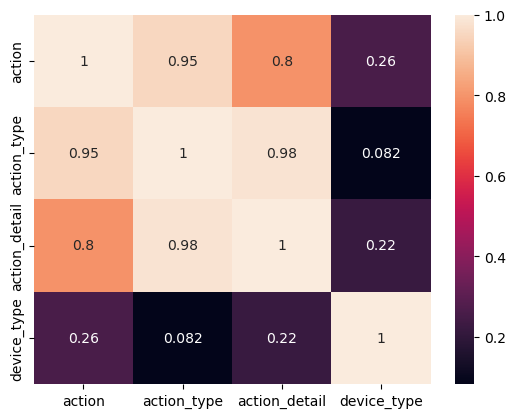

In [45]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

Most correlated features based on Cramer's V score:

1. action_detail and action_type: 0.98.
2. action_type and action: 0.95.
3. action_detail and action: 0.80. 

Based on the analysis done in the section 1.7.4, action detail has 155 unique classes while action_type has 10. Action detail is 98% represented by action_type. Thus, we may keep only action_type, which is the one with less classes. Similarly, we chose the following features:

1. action_type.
2. action_type.
3. action_detail. 

Thus, we may remove action_detail and action columns.

# 2. Feature Engineering

In [46]:
df2 = df1.copy()

## 2.4. Feature Engineering

We need variables which model the phenomenon. We derive a feature (derived) from an attribute (original from a dataset). The main motivation is to increase model performance.

- We must always think about how much time takes to happen something.
- We must break date into day, week, month, year and other time features as we may see below (date derivations).

In [47]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [48]:
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,2015-06-29,-unknown-,37,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [49]:
# days from first active up to first booking
df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] - df2['first_active']).apply(lambda x: x.days)

# days from first active up to account created
df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)

# days from account createad up to first booking
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x: x.days)

# ================== First Active ==================

# year first active
df2['year_first_active'] = df2['first_active'].dt.year

# month first active
df2['month_first_active'] = df2['first_active'].dt.month

# day first active
df2['day_first_active'] = df2['first_active'].dt.day

# day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

# week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear

# ================== First Booking ==================

# year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

# month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

# ================== First Account Created =================

# year first booking
df2['year_account_created'] = df2['date_account_created'].dt.year

# month  account_created
df2['month_account_created'] = df2['date_account_created'].dt.month

# day  account_created
df2['day_account_created'] = df2['date_account_created'].dt.day

# day of week  account_created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year  account_created
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_9977/1257941504.py:26: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear
/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_9977/1257941504.py:43: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear
/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_9977/1257941504.py:60: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


In [50]:
df2.shape

(207386, 35)

# 3. Feature Filtering and Selection

In [51]:
df3 = df2.copy()

## 3.1. Feature Filtering

In [52]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are not people older than 122    
df3 = df3[( df3['age'] > 15 ) & ( df3['age'] < 122 )]

# secs_elapsed - there is no possible 0 secs elapsed on website
df_sessions = df_sessions[df_sessions['secs_elapsed'] > 0]

## 3.2. Columns Selection

Based on sections 1.7.5 and 1.7.6, we chose the following columns to be removed. We must have the minimum number of columns in order to avoid model overfitting.

We tested the model after the above removal, yet it was not enough. In a new CRISP cycle, we used the profilind pandas to identify features with high correlation.  

In [53]:
cols_drop_users = ["first_device_type", 
                   "first_browser", 
                   "affiliate_provider", 
                   "date_account_created", 
                   "timestamp_first_active", 
                   "date_first_booking", 
                   "first_active",
                  ]
cols_drop_sessions = ["action_detail", "action"]

df3 = df3.drop(cols_drop_users, axis=1)
df_sessions = df_sessions.drop(cols_drop_sessions, axis=1)

# 4. Balanced Dataset

This section is necessary when there is a great imbalance between classes of a dataset. When this phenomenon occurs, the model becomes biased. In this section, we balanced our dataset. After balance, we may look at accuracy instead of balanced accuracy - this metric does not make sense anymore since the data will be balanced.

**CAUTION:** we use balanced data to train the model, not for Exploratory Data Analysis, since they are synthetic data.

In [54]:
df4 = df3.copy()

To balance our data, we have the following techniques:

1. Collect more data: **(a)** use webscraping, **(b)** wait data generation, or **(c)** increase the period of time for collecting.
2. Resampling the data: **(a)** undersampling and **(b)** oversampling.
3. Generate synthetic examples based on existing ones.
4. Attribute a bias to the model: tell the model the classes with more examples.

In [55]:
df4.shape

(206593, 28)

In [56]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df4.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical
col_cat = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop(['id', 'country_destination'], axis=1).columns.tolist()

# encoding
df4_dummy = pd.DataFrame(ohe.fit_transform(df4[col_cat]).toarray(), index=df4.index)

# join numerical and categorical
df42 = pd.concat([df4[col_num], df4_dummy], axis=1)
df42.shape

(206593, 71)

## 4.1. Random Undersampling

This technique consists of taking random samples from a majority class until the amount of data is the same of a minority class. We use this technique when (1) the minority class is enough for training and (2) the problem is not naturally imbalanced (e.g.: Fraud problems are naturally imbalanced). 

**Advantages:** Easy and fast technique.

**Disadvantages:** (1) Reduction of data; (2) Underfitting. 

In [57]:
# define sampler
undersampling = us.RandomUnderSampler(sampling_strategy="all", random_state=32)

# apply sampler
X_under, y_under = undersampling.fit_resample(df42, df4['country_destination'])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [58]:
df4['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [59]:
y_under.value_counts()

AU       213
CA       213
DE       213
ES       213
FR       213
GB       213
IT       213
NDF      213
NL       213
PT       213
US       213
other    213
Name: country_destination, dtype: int64

In [60]:
y_under

0          AU
1          AU
2          AU
3          AU
4          AU
        ...  
2551    other
2552    other
2553    other
2554    other
2555    other
Name: country_destination, Length: 2556, dtype: object

In [61]:
X_under

,age,signup_flow,days_from_first_active_until_booking,days_from_first_active_until_account_created,days_from_account_created_until_first_booking,year_first_active,month_first_active,day_first_active,day_of_week_first_active,week_of_year_first_active,...,41,42,43,44,45,46,47,48,49,50
0,35,12,33,0,33,2013,12,31,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,35,0,12,0,12,2013,2,24,6,8,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,38,0,9,0,9,2012,12,7,4,49,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,46,0,82,0,82,2012,9,29,5,39,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,37,0,1,0,1,2013,5,13,0,20,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,30,0,2,0,2,2014,6,11,2,24,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2552,37,0,21,0,21,2013,6,26,2,26,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2553,20,0,2,0,2,2013,9,24,1,39,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2554,25,0,0,0,0,2013,6,11,1,24,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [62]:
# numerical data
df43 = X_under[col_num]

# categorical data
df44 = X_under.drop(col_num, axis=1)
df45 = pd.DataFrame(ohe.inverse_transform(df44), columns=col_cat, index=df44.index)

# join numerical categorical
df46 = pd.concat([df43, df45], axis=1)
df46['country_destination'] = y_under

## 4.2. Random Oversampling

This technique consists of taking random samples from a minority class until the amount of data is the same of a manjority class. We use this technique when (1) it is not possible to collect more data of the classes and (2) the problem is not naturally imbalanced (e.g.: Fraud problems). 

**Advantages:** Easy and fast technique.

**Disadvantages:** (1) Enhancement of repetition for training examples; (2) Enhancement of overfitting probability; (3) No further information about the phenomenon, as we use data from sample.

In [63]:
# define sampler
oversampling = oversamp.RandomOverSampler(sampling_strategy='all', random_state=32)

# apply sampler
X_over, y_over = oversampling.fit_resample(df42, df4['country_destination'])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [64]:
df4['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [65]:
y_over.value_counts()

NDF      119810
US       119810
other    119810
CA       119810
FR       119810
ES       119810
GB       119810
IT       119810
PT       119810
NL       119810
DE       119810
AU       119810
Name: country_destination, dtype: int64

In [66]:
# numerical data
df47 = X_over[col_num]

# categorical data
df48 = X_over.drop(col_num, axis=1)
df49 = pd.DataFrame(ohe.inverse_transform(df48), columns=col_cat, index=df48.index)

# join numerical categorical
df50 = pd.concat([df47, df49], axis=1)
df50['country_destination'] = y_over

## 4.3. SMOTE + TOMEKLINK

Instead of taking samples from our data, we may generate synthetic data. One manner is using SMOTE technique. 

**Advantages:** New examples and less chance for overfitting.

**Disadvantages:** (1) The majority class is not considered; (2) Enhancement of Noise for classes with overlap; (3) Slow process for data with a high dimensionality. 

In [67]:
# We may use this dictionary as the sampling_strategy parameter 
#
#ratio_balanced =  {'NDF': 119810,
#                   'US':  60800,
#                   'other': 45000,
#                   'FR': 45000,
#                   'IT': 45000,
#                   'GB': 45000,
#                   'ES': 45000,
#                   'CA': 45000,
#                   'DE': 45000,
#                   'NL': 45000,
#                   'AU': 45000,
#                   'PT': 45000}

In [68]:
# define sampler
#smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)

# apply sampler
#X_smt, y_smt = smt.fit_resample(df42, df4['country_destination'])

**This technique is completely unfeasible due to its time consumption. More than 2 hours in my local machine were not enough to finish this process.** 

# 5. Exploratory Data Analysis (EDA)

The main objectives of this section is:

1. To acquire business experience from data.
2. To generate insights to the business team.
3. To evaluate features impact over the phenomenon.

In [69]:
df5 = df4.copy()

In [70]:
df5.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,first_affiliate_tracked,signup_app,country_destination,...,year_first_booking,month_first_booking,day_first_booking,day_of_week_first_booking,week_of_year_first_booking,year_account_created,month_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created
0,gxn3p5htnn,-unknown-,37,facebook,0,en,direct,untracked,Web,NDF,...,2015,6,29,0,27,2010,6,28,0,26
1,820tgsjxq7,MALE,38,facebook,0,en,seo,untracked,Web,NDF,...,2015,6,29,0,27,2011,5,25,2,21
2,4ft3gnwmtx,FEMALE,56,basic,3,en,direct,untracked,Web,US,...,2010,8,2,0,31,2010,9,28,1,39
3,bjjt8pjhuk,FEMALE,42,facebook,0,en,direct,untracked,Web,other,...,2012,9,8,5,36,2011,12,5,0,49
4,87mebub9p4,-unknown-,41,basic,0,en,direct,untracked,Web,US,...,2010,2,18,3,7,2010,9,14,1,37


## 5.1. Univariate Analysis - Feature Behavior (Balanced Dataset)

The main objective of this section is to know better our variables. Min? Max? Distribution? 

For profiling, it is important to find variables which does not have information. These variables are the ones with a high number of 0 (non-expected) and the ones with a high correlation with other variable. These features are removed in the section 7.  

We consideres only the Oversampling resulted dataset to select the high correlated variables, since it has more available data to take any decision.

### 5.1.1. Random Undersampling 

In [71]:
# Under sampling
#proof = ProfileReport(df46)
#proof.to_notebook_iframe()

### 5.1.2. Random Oversampling

In [72]:
# Over sampling
#proof = ProfileReport(df50)
#proof.to_notebook_iframe()

In [73]:
#profile = ProfileReport(df50, title='Airbnb Booking')
#profile.to_file(output_file='airbnb_booking_statistics_after_cleaning.html')

The high correlated variables are:

1. signup_flow (1 and 6).
2. days_from_first_active_until_booking (2 and 3).
3. days_from_account_created_until_first_booking (2 and 3).
4. day_of_week_first_active (4 and 5).
5. day_of_week_account_created (4 and 5).
6. signup_app (1 and 6). 

In [74]:
df50.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1437720.0,37.331894,12.130432,16.0,30.0,37.0,38.0,115.0
signup_flow,1437720.0,2.177921,6.212567,0.0,0.0,0.0,0.0,25.0
days_from_first_active_until_booking,1437720.0,97.385268,213.270739,0.0,1.0,5.0,69.0,2293.0
days_from_first_active_until_account_created,1437720.0,0.282520,12.238842,0.0,0.0,0.0,0.0,1456.0
days_from_account_created_until_first_booking,1437720.0,97.102747,212.937107,-349.0,1.0,5.0,69.0,2001.0
year_first_active,1437720.0,2012.954735,0.955800,2009.0,2012.0,2013.0,2014.0,2014.0
month_first_active,1437720.0,5.947240,3.111364,1.0,4.0,6.0,8.0,12.0
day_first_active,1437720.0,15.851750,8.752215,1.0,8.0,16.0,23.0,31.0
day_of_week_first_active,1437720.0,2.773413,1.975918,0.0,1.0,3.0,4.0,6.0
week_of_year_first_active,1437720.0,24.087601,13.474984,1.0,14.0,23.0,34.0,53.0


Since the selected variables have the same count, we must choose any variable of a pair. They were removed in the section Feature Selection.

**Fast to execute, but it makes the notebook a too big file. That's why we commented the code and created a HTML file.**

## 5.2. Bivariate Analysis - Hypotheses Validation (Imbalanced Dataset)

### 5.2.1. Hypotheses Mind Map

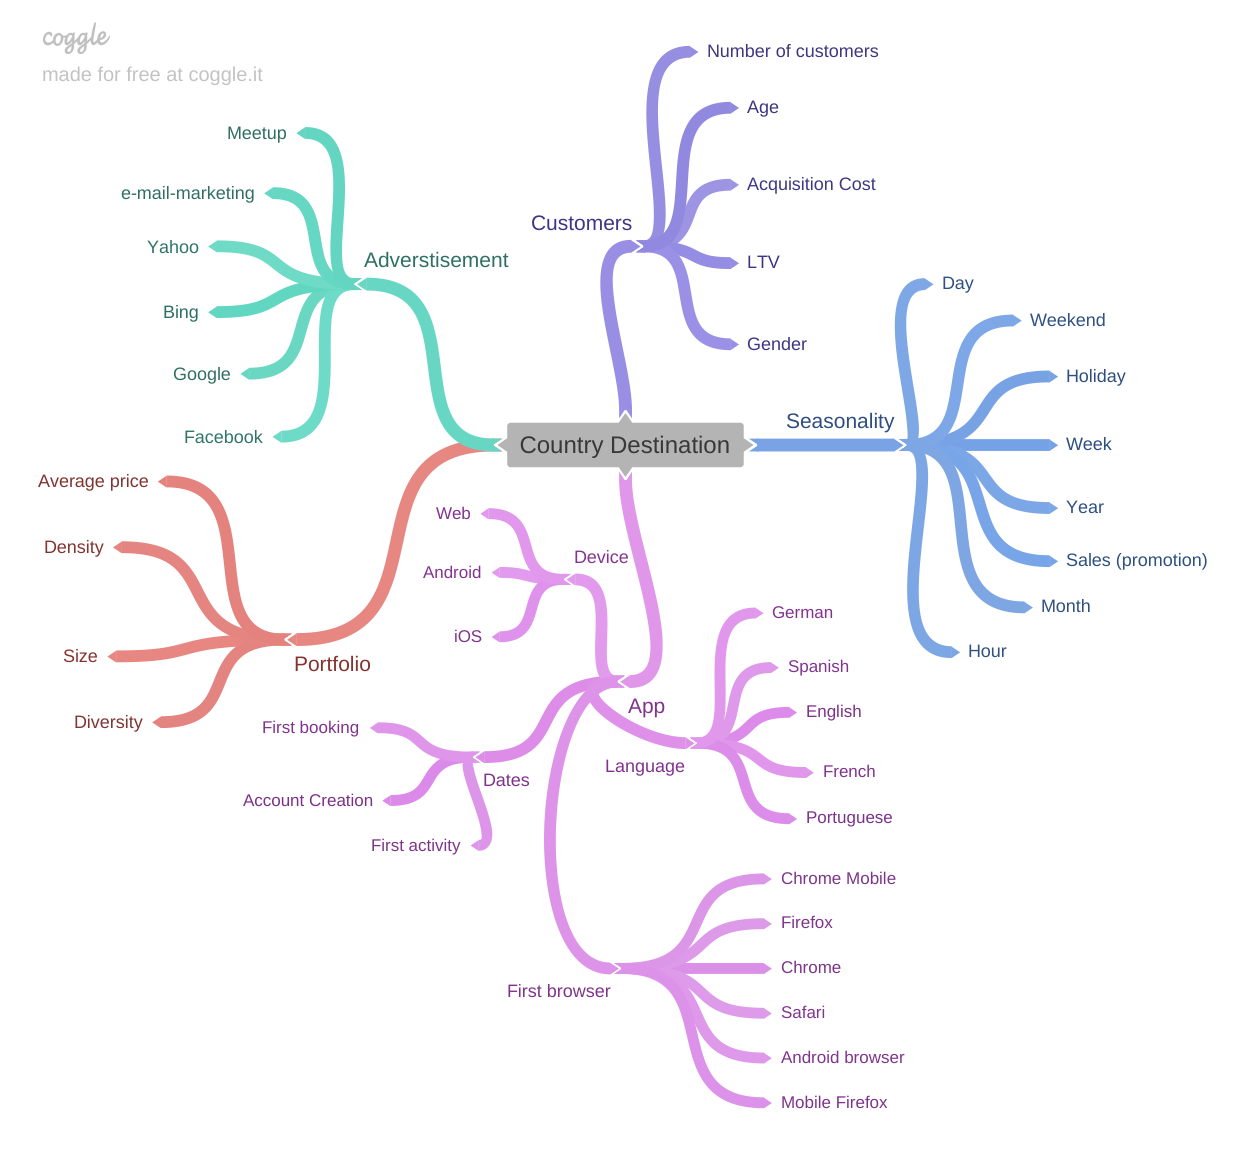

In [75]:
Image("images/HypothesesMindMap.png")

### 5.2.2. Hypotheses Validation

Based on the mind map above, we generated and tested the hypotheses in this section.

The main objective of this section is to evaluate the impact of the variables over the response variable.

**H01.** To every destiny, users take 15 days, on median, to do the first booking, since their first activity. 

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_booking'>

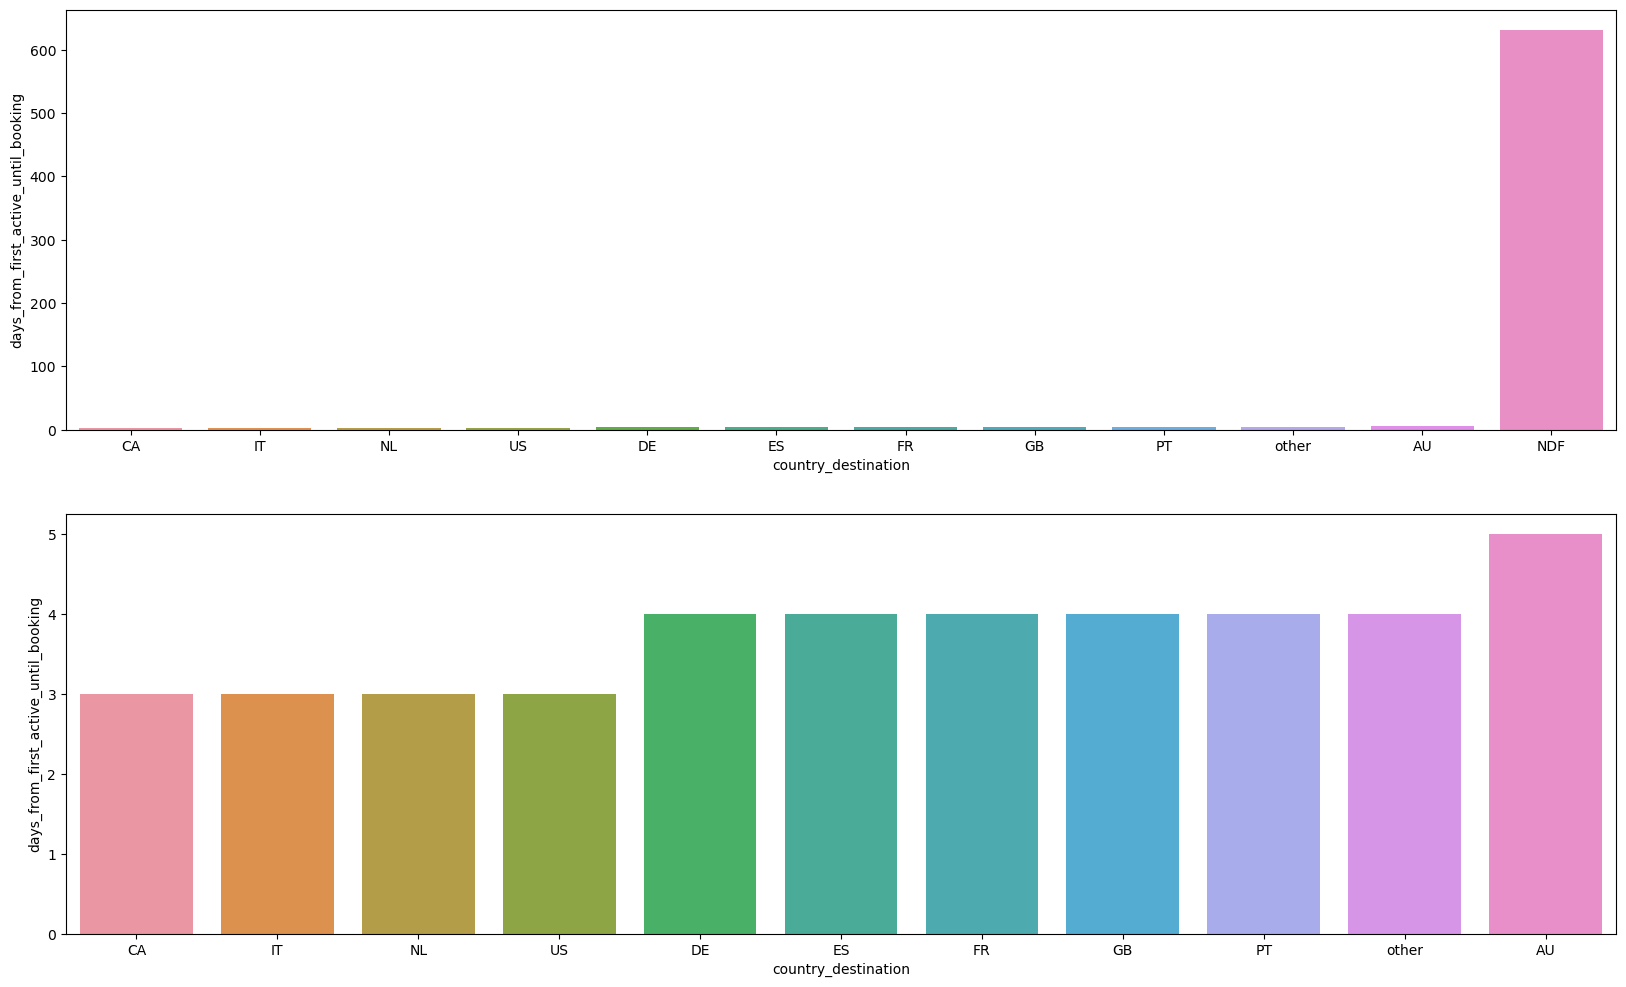

In [76]:
plt.figure(figsize=(20, 12))

# all country destination
plt.subplot(2, 1, 1)
aux01 = df5[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_booking', 
             data=aux01.sort_values('days_from_first_active_until_booking'))

# remove NDF - out of scale
plt.subplot(2, 1, 2)
aux02 = df5[df5['country_destination'] != 'NDF']
aux02 = aux02[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_booking', 
             data=aux02.sort_values( 'days_from_first_active_until_booking' ))

<AxesSubplot:xlabel='days_from_first_active_until_booking', ylabel='Count'>

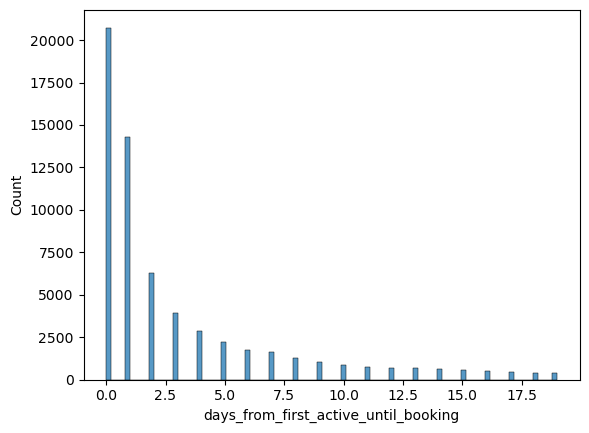

In [77]:
aux03 = df5[(df5["days_from_first_active_until_booking"] < 20)]["days_from_first_active_until_booking"]
sns.histplot(aux03)

**FALSE**

- They took not event 5 days, on median, to do their first booking to any country destination.
- We may see at the distribution chart above that the majority do the booking until 5 days.

**H02.** To every destiny, users take 3 days, on median, from first activity until create an account.

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_account_created'>

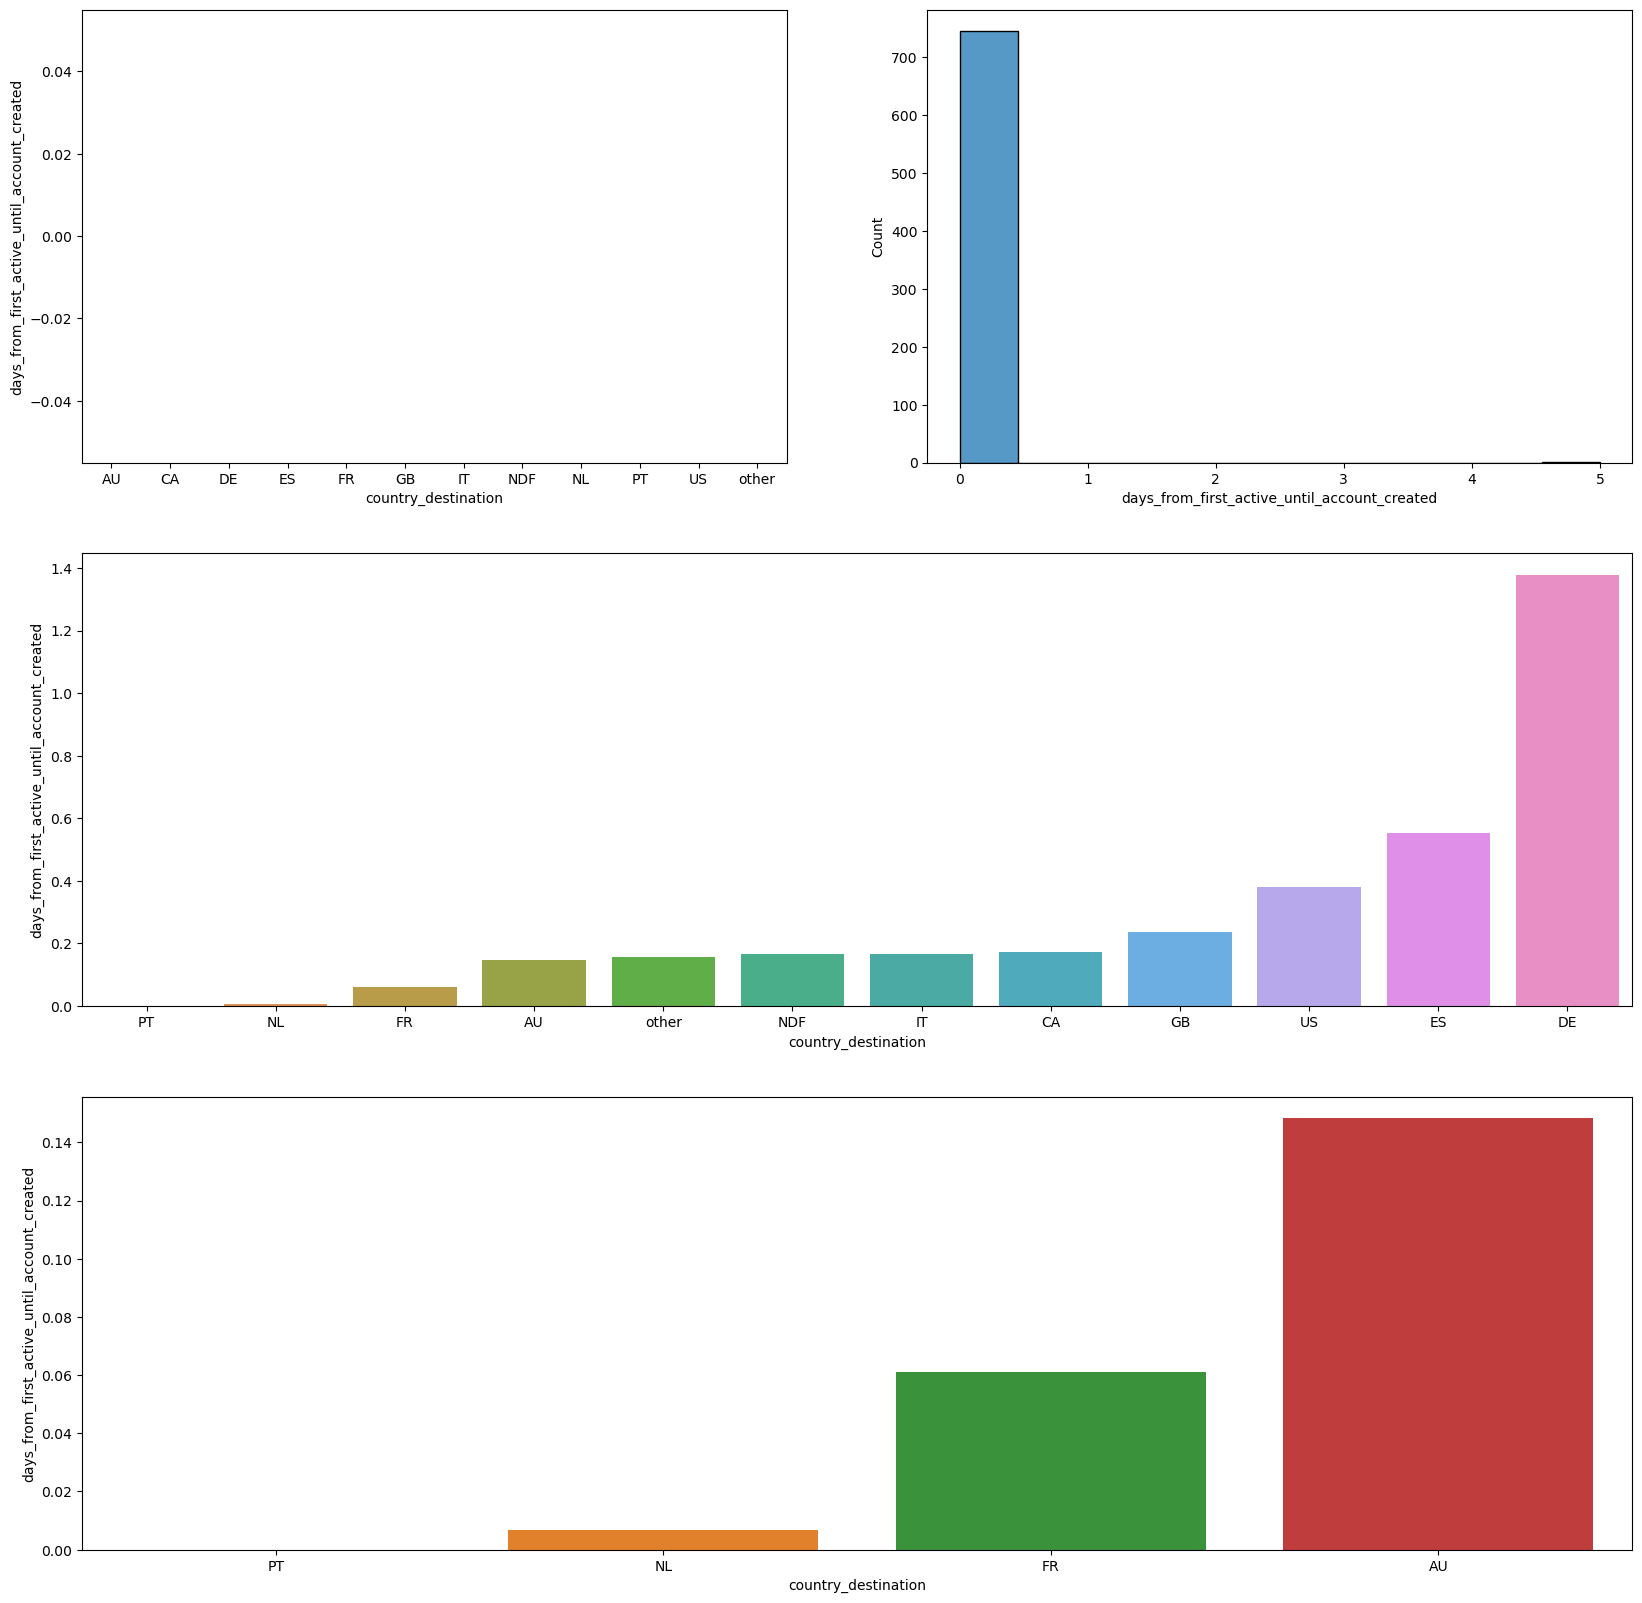

In [78]:
plt.figure(figsize=(20, 20))

grid = gridspec.GridSpec(3, 2)

# USING MEDIAN
plt.subplot(grid[0,0])
aux01 = df5[(df5["days_from_first_active_until_account_created"] >= 0)][["days_from_first_active_until_account_created", "country_destination"]].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_account_created', 
             data=aux01.sort_values('days_from_first_active_until_account_created'))

plt.subplot(grid[0,1])
aux03 = df5[(df5["country_destination"] == "NL") & (df5["days_from_first_active_until_account_created"] >= 0)]["days_from_first_active_until_account_created"]
sns.histplot(aux03)

# USING MEAN
plt.subplot(grid[1,:])
aux04 = df5[(df5["days_from_first_active_until_account_created"] >= 0)][["days_from_first_active_until_account_created", "country_destination"]].groupby('country_destination').mean().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_account_created', 
             data=aux04.sort_values('days_from_first_active_until_account_created'))

plt.subplot(grid[2,:])
aux05 = df5[(df5["days_from_first_active_until_account_created"] >= 0) & ((df5["country_destination"] == "NL") | (df5["country_destination"] == "PT") | (df5["country_destination"] == "FR") | (df5["country_destination"] == "AU"))][["days_from_first_active_until_account_created", "country_destination"]].groupby('country_destination').mean().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_account_created', 
             data=aux05.sort_values('days_from_first_active_until_account_created'))


**TRUE**

- Users usually take 0 days, on median, from first activity until they create an account. That's why the two first charts seems to be wrong. 
- Therefore, we decided to use the mean. The result is that users take less than 2 days, on mean, to first activity until an account creation.
- Users with Portugal, Netherlands, France and Australia as country destination take less than 1 day to create an account.

**H03.** The number of bookings to US increase 20% yearly during the summer.

Text(0, 0.5, 'Delta (%)')

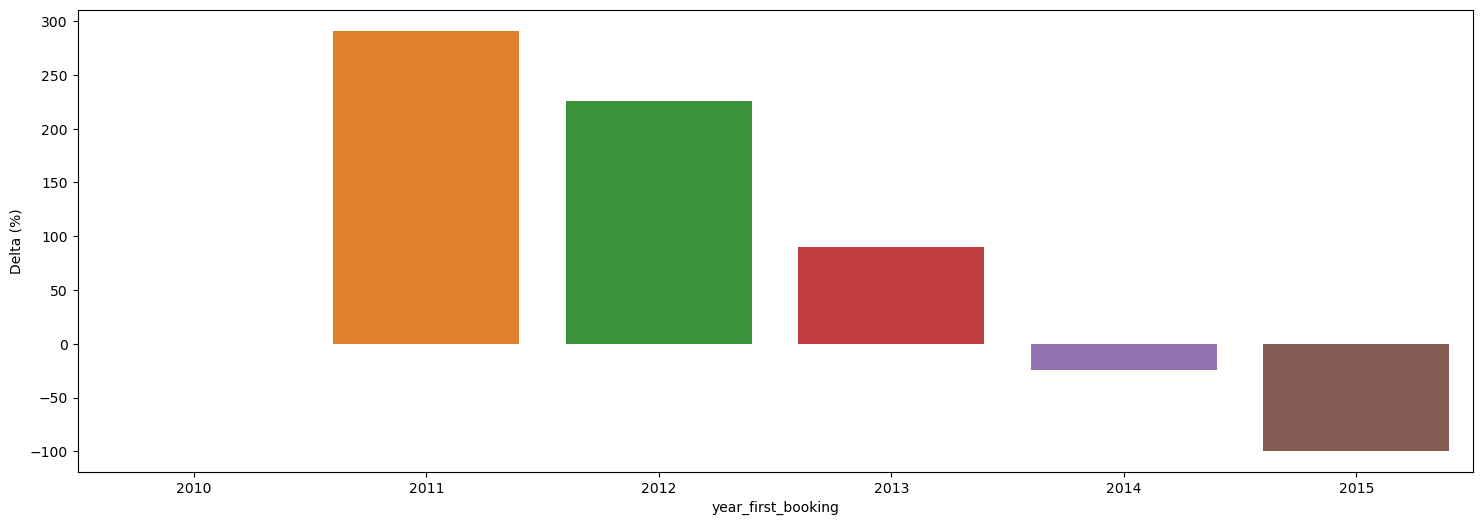

In [79]:
aux01 = df5[['year_first_booking', 'month_first_booking', 'country_destination']].\
                groupby(['year_first_booking', 'month_first_booking', 'country_destination']).\
                size().reset_index().rename( columns={0:'count'})

# select only summer
aux01 = aux01[(aux01['month_first_booking'].isin([6, 7, 8, 9])) & (aux01['country_destination'] == 'US')]

aux02 = aux01[['year_first_booking', 'count']].groupby('year_first_booking').sum().reset_index()

aux02['delta'] = 100*aux02['count'].pct_change().fillna(0)

plt.figure( figsize=(18,6))
sns.barplot( x='year_first_booking', y='delta', data=aux02)
plt.ylabel("Delta (%)")

**FALSE**

- Based on the **waterfall chart** above, there was a higher increase up to 2013. However, in 2014 and 2015 there was a decrease.

**H04.** Female users booking are 10% higher to out of US than inside. 

In [80]:
df5["gender"].unique()

array(['-unknown-', 'MALE', 'FEMALE', 'OTHER'], dtype=object)

Text(0.5, 0, 'Country destination')

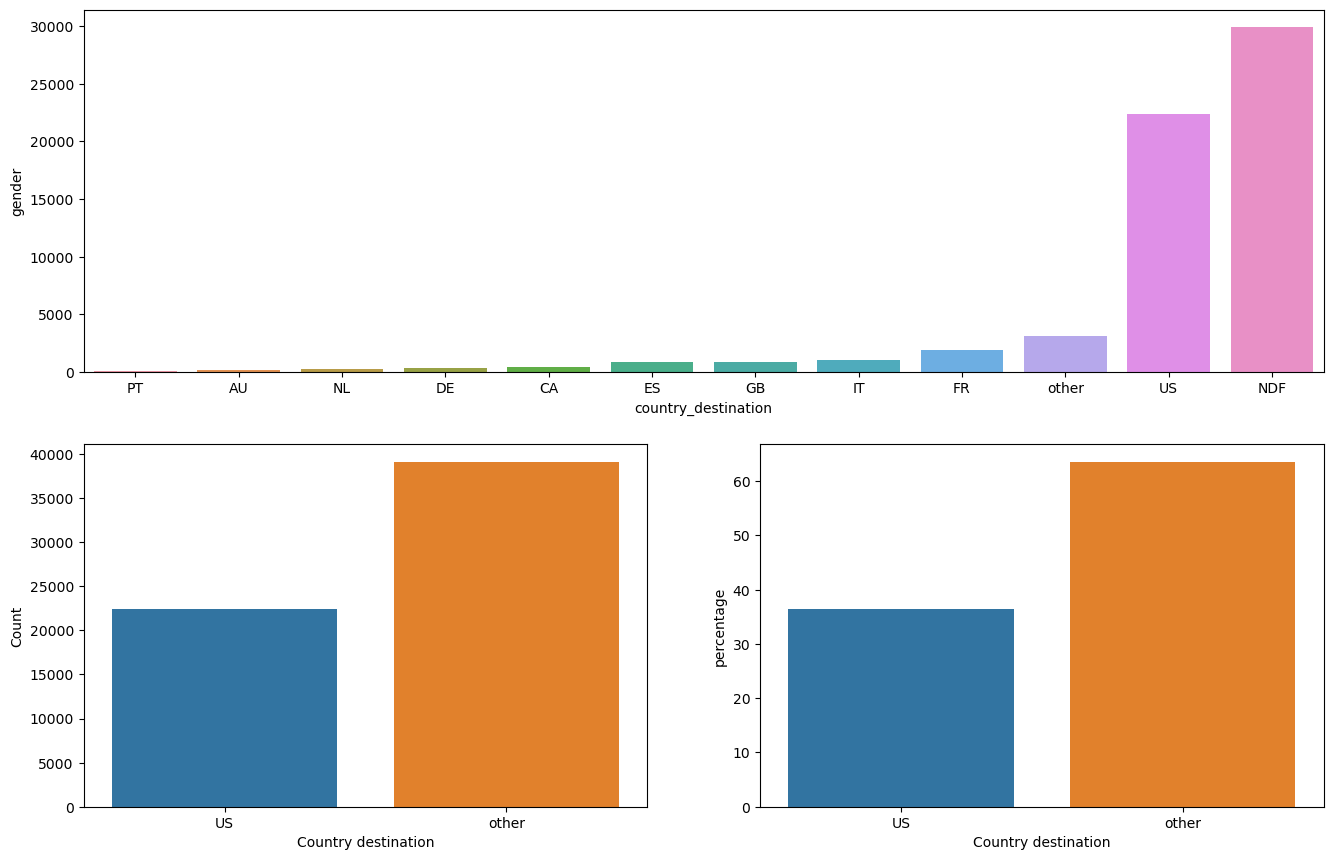

In [81]:
aux01 = df5[df5["gender"] == "FEMALE"][["gender", "country_destination"]].groupby("country_destination").count().reset_index()

aux02 = df5.copy()

aux02.loc[(aux02["country_destination"] == "US") & (aux02["gender"] == "FEMALE"), "count_destination"] = 1
aux02.loc[(aux02["country_destination"] == "US") & (aux02["gender"] == "FEMALE"), "country_dest"] =  "US"

aux02.loc[(aux02["country_destination"] != "US") & (aux02["gender"] == "FEMALE"), "count_destination"] = 0
aux02.loc[(aux02["country_destination"] != "US") & (aux02["gender"] == "FEMALE"), "country_dest"] = "other"

aux03 = aux02[["count_destination", "country_dest"]].groupby("country_dest").count().reset_index()

aux03.loc[aux03["country_dest"] == "US", "percentage"] = 100*aux03["count_destination"][0]/(aux03["count_destination"][0]+aux03["count_destination"][1])
aux03.loc[aux03["country_dest"] == "other", "percentage"] = 100*aux03["count_destination"][1]/(aux03["count_destination"][0]+aux03["count_destination"][1])

pd.set_option('display.float_format', lambda x: '%.2f' % x)

plt.figure(figsize=(16,16))

grid = gridspec.GridSpec(3, 2)

plt.subplot(grid[0,:])
sns.barplot(x="country_destination", y="gender", data=aux01.sort_values("gender"))

plt.subplot(grid[1,0])
sns.barplot(x="country_dest", y="count_destination", data=aux03)
plt.xlabel("Country destination")
plt.ylabel("Count")

plt.subplot(grid[1,1])
sns.barplot(x="country_dest", y="percentage", data=aux03)
plt.xlabel("Country destination")

**FALSE**

- The country destination with the highest count for female is US.
- Comparing with each country destination, US has the best performance for female.
- However, the total amount of bookings for US is lower than the sum of other countries.
- Female bookings for US is around 20% lower than those to out of US.

**H05.** Google Marketing channel represents 40% of the bookings to out of US.

<AxesSubplot:xlabel='marketing_channel', ylabel='percentage'>

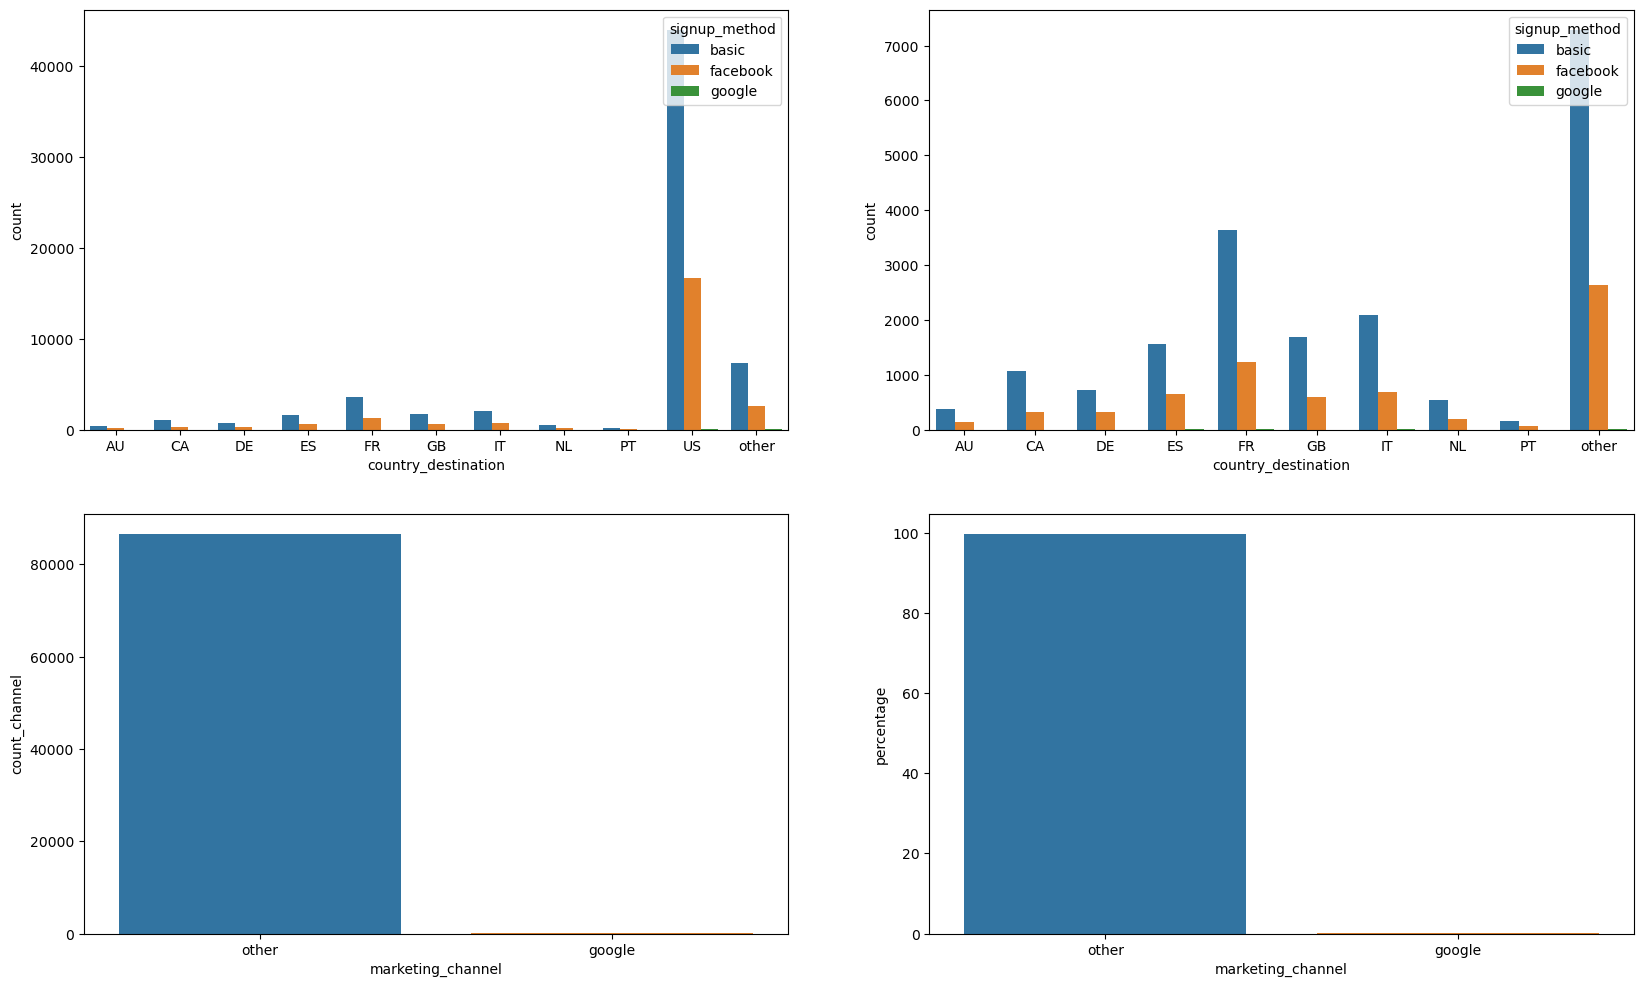

In [82]:
aux01 = df5[["country_destination", "signup_method"]].groupby(["country_destination", "signup_method"]).size().reset_index().rename( columns={0:'count'})
aux02 = aux01[aux01["country_destination"] != "NDF"]
aux09 = aux02[aux02["country_destination"] != "US" ]

aux10 = aux02[["count", "signup_method"]].groupby("signup_method").sum().reset_index()

aux10.loc[(aux10["signup_method"] == "google"), "count_channel"] = aux10["count"][2]
aux10.loc[(aux10["signup_method"] == "google"), "marketing_channel"] = "google"

aux10.loc[(aux10["signup_method"] != "google"), "count_channel"] = aux10["count"][0] + aux10["count"][1]
aux10.loc[(aux10["signup_method"] != "google"), "marketing_channel"] = "other"

aux10 = aux10.drop(columns=["signup_method", "count"])
aux10 = aux10.drop_duplicates().reset_index()

aux10.loc[aux10["marketing_channel"] == "google", "percentage"] = 100*aux10["count_channel"][1]/(aux10["count_channel"][0]+aux10["count_channel"][1])
aux10.loc[aux10["marketing_channel"] == "other", "percentage"] = 100*aux10["count_channel"][0]/(aux10["count_channel"][0]+aux10["count_channel"][1])

pd.set_option('display.float_format', lambda x: '%.2f' % x)

plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
sns.barplot(x="country_destination", y="count", hue="signup_method", data=aux02)

plt.subplot(2,2,2)
sns.barplot(x="country_destination", y="count", hue="signup_method", data=aux09)

plt.subplot(2,2,3)
sns.barplot(x="marketing_channel", y="count_channel", data=aux10)

plt.subplot(2,2,4)
sns.barplot(x="marketing_channel", y="percentage", data=aux10)

**FALSE**

- The marketing channels mostly used from users who go outside US are basic and facebook.
- These channels represents almost 100% of our base. 

**H06.** Country destination US represent more than 20% on every channel. 

Text(0.5, 0, 'channel')

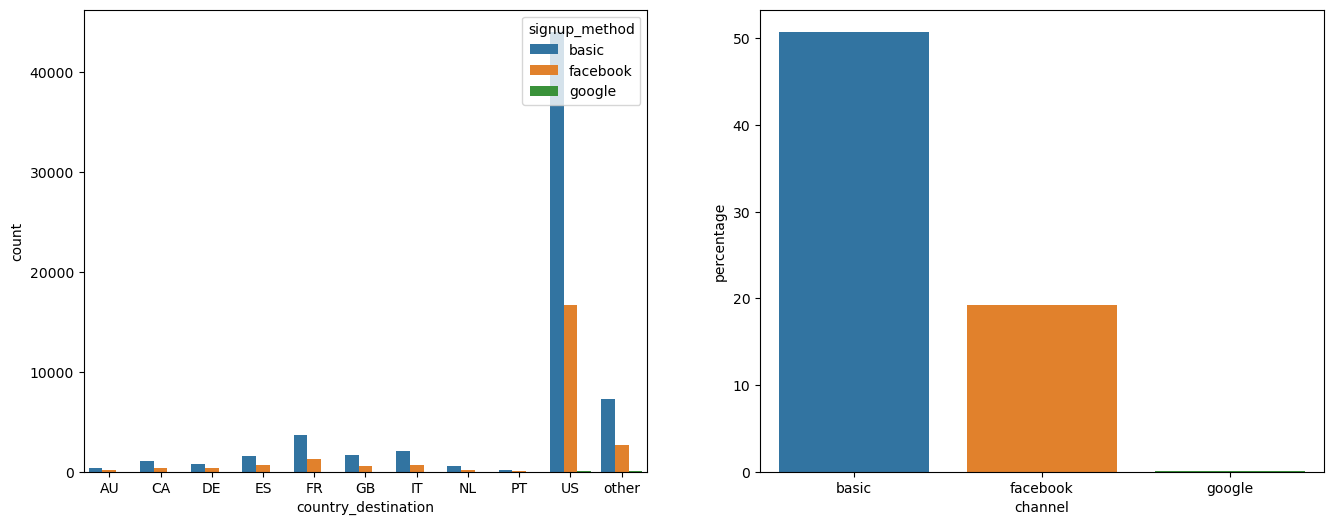

In [83]:
aux01 = df5[df5["country_destination"] != "NDF"][["country_destination", "signup_method"]].groupby(["country_destination", "signup_method"]).size().reset_index().rename(columns={0:'count'})

aux01["total_count"] = aux01["count"].sum()
aux01["percentage"] = aux01.apply(lambda x: 100*x["count"]/x["total_count"], axis=1)
aux02 = aux01[aux01["country_destination"] == "US"]

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
sns.barplot(x="country_destination", y="count", hue="signup_method", data=aux01)

plt.subplot(1,2,2)
sns.barplot(x="signup_method", y="percentage", data=aux02)
plt.xlabel("channel")

**FALSE**

- Although US is the major destiny and basic channel represents more than 50% of all bookings, only this channel represents more than 20%.
- Facebook and Google represents, respectively, 19.20% and 0.09%. 

**H07.** The average age is 35 years old to every country destination. 

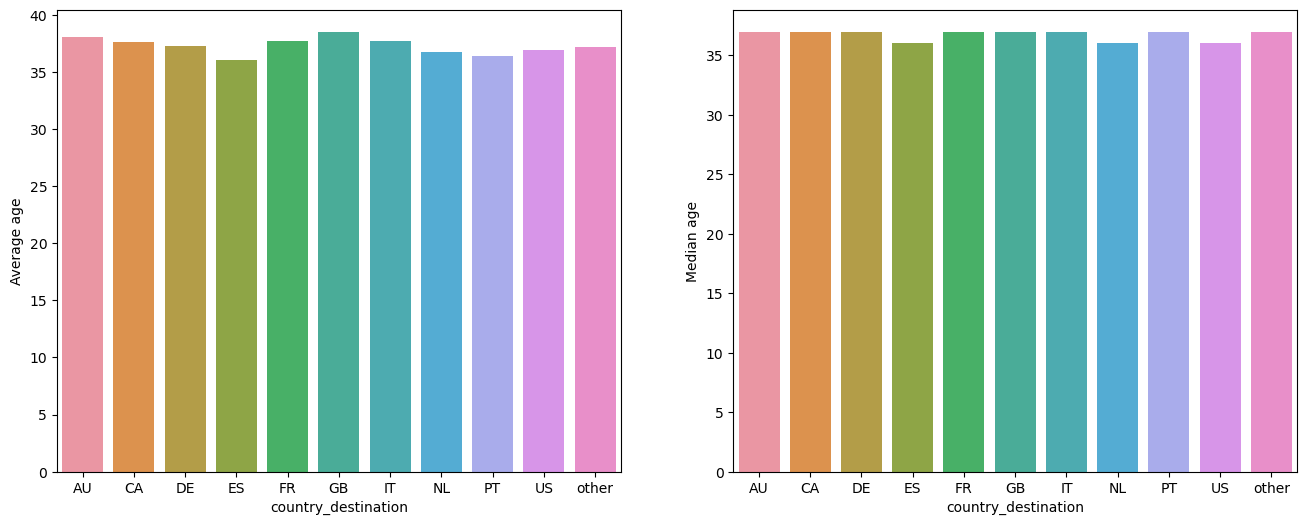

In [84]:
aux01 = df5[df5["country_destination"] != "NDF"][["age", "country_destination"]].\
                                groupby("country_destination").mean().reset_index()

aux02 = df5[df5["country_destination"] != "NDF"][["age", "country_destination"]].\
                                groupby("country_destination").median().reset_index()

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
sns.barplot(x="country_destination", y="age", data=aux01)
plt.ylabel("Average age")

plt.subplot(1,2,2)
sns.barplot(x="country_destination", y="age", data=aux02)
plt.ylabel("Median age");

**TRUE**

- Since the average and the median age are very close to 35 for every country destination, we consider this hypothesis as true. 
- As the average is a float number, the assumption was very close to the actual value. 

**H08.** The users percentage who uses Airbnb in the English language to book is higher than 90% to every country destination. 

In [85]:
aux01 = df5[["language", "country_destination"]].groupby(["country_destination", "language"]).size().reset_index()\
                                        .rename(columns={0:"count"})

aux02 = aux01[["country_destination", "count"]].groupby("country_destination").sum().reset_index()

In [86]:
aux01

,country_destination,language,count
0,AU,de,3
1,AU,en,519
2,AU,fr,2
3,AU,zh,2
4,CA,de,1
...,...,...,...
152,other,ru,14
153,other,sv,7
154,other,th,1
155,other,tr,4


In [87]:
aux02

,country_destination,count
0,AU,526
1,CA,1385
2,DE,1033
3,ES,2203
4,FR,4881
5,GB,2285
6,IT,2776
7,NDF,119810
8,NL,746
9,PT,213


In [88]:
for i in range(len(aux01)):
        
        if (aux01.loc[i, "country_destination"] == "AU"):
            aux01.loc[i, "total_count"] = 526

        elif (aux01.loc[i, "country_destination"] == "CA"):
            aux01.loc[i, "total_count"] = 1385

        elif (aux01.loc[i, "country_destination"] == "DE"):
            aux01.loc[i, "total_count"] = 1033

        elif (aux01.loc[i, "country_destination"] == "ES"):
            aux01.loc[i, "total_count"] = 2203

        elif (aux01.loc[i, "country_destination"] == "FR"):
            aux01.loc[i, "total_count"] = 4881

        elif (aux01.loc[i, "country_destination"] == "GB"):
            aux01.loc[i, "total_count"] = 2285

        elif (aux01.loc[i, "country_destination"] == "IT"):
            aux01.loc[i, "total_count"] = 2776
            
        elif (aux01.loc[i, "country_destination"] == "NDF"):
            aux01.loc[i, "total_count"] = 119810

        elif (aux01.loc[i, "country_destination"] == "NL"):
            aux01.loc[i, "total_count"] = 746

        elif (aux01.loc[i, "country_destination"] == "PT"):
            aux01.loc[i, "total_count"] = 213 

        elif (aux01.loc[i, "country_destination"] == "US"):
            aux01.loc[i, "total_count"] = 60800

        else:
            aux01.loc[i, "total_count"] = 9935

In [89]:
aux01["percentage"] = aux01.apply(lambda x: 100*x["count"]/x["total_count"], axis=1)

In [90]:
aux01

,country_destination,language,count,total_count,percentage
0,AU,de,3,526.00,0.57
1,AU,en,519,526.00,98.67
2,AU,fr,2,526.00,0.38
3,AU,zh,2,526.00,0.38
4,CA,de,1,1385.00,0.07
...,...,...,...,...,...
152,other,ru,14,9935.00,0.14
153,other,sv,7,9935.00,0.07
154,other,th,1,9935.00,0.01
155,other,tr,4,9935.00,0.04


<AxesSubplot:xlabel='country_destination', ylabel='percentage'>

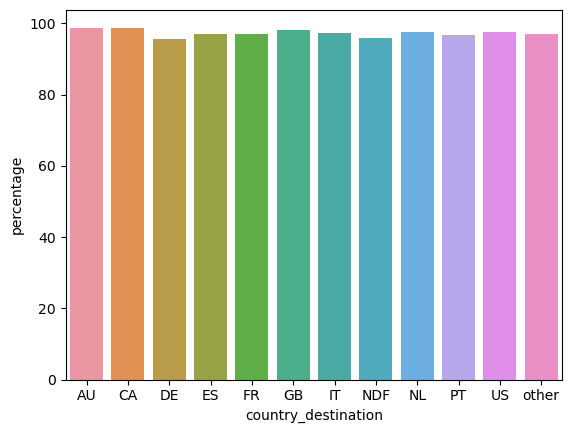

In [91]:
aux03 = aux01[aux01["language"] == "en"][["country_destination", "percentage"]]
sns.barplot(x="country_destination", y="percentage", data=aux03)

**TRUE**

- The percentage of users who use English language in the Airbnb is higher than 90% to every country destination.
- As almost 100% of the variable language is English, we must remove this variable, because it does not helps to train the model and makes more difficult to encode. 
- This variable was removed in the section 7 - Feature Selection. 

**H09.** The number of bookings per year increases. 

Text(0, 0.5, 'Delta (%)')

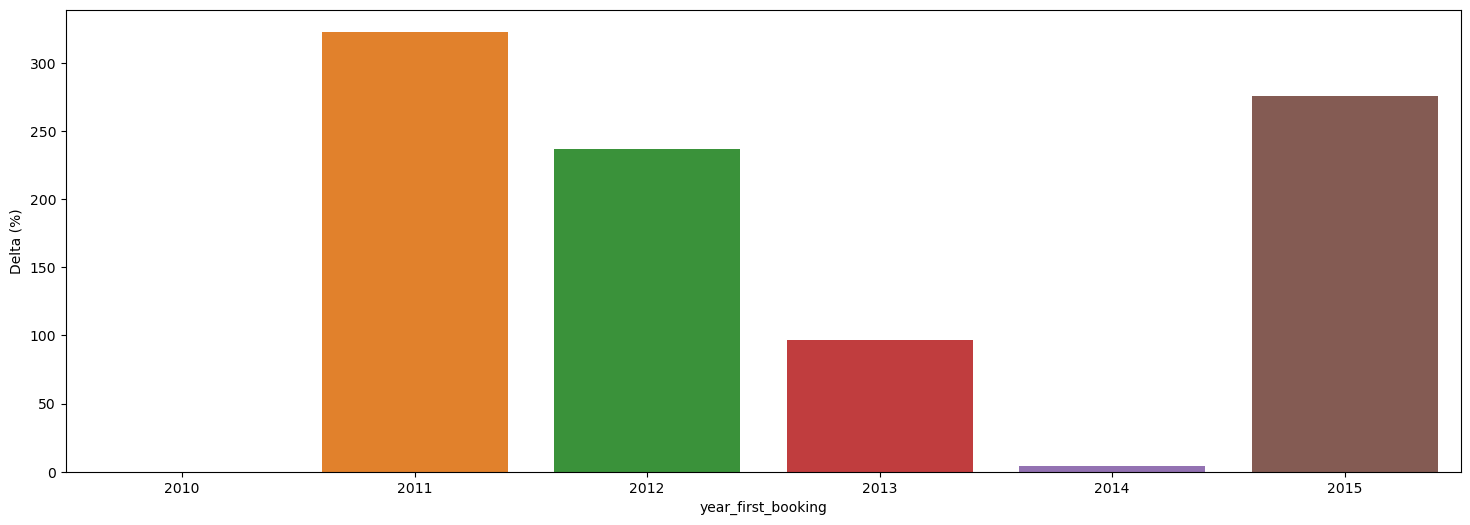

In [92]:
aux01 = df5[["id", "year_first_booking"]].groupby("year_first_booking").count().reset_index()

aux01['delta'] = 100*aux01['id'].pct_change().fillna(0)

aux01 = aux01.rename(columns={"id": "number_bookings"})

plt.figure(figsize=(18,6))
sns.barplot(x='year_first_booking', y='delta', data=aux01)
plt.ylabel("Delta (%)")

In [93]:
aux01

,year_first_booking,number_bookings,delta
0,2010,1108,0.00
1,2011,4690,323.29
2,2012,15797,236.82
3,2013,31083,96.77
4,2014,32334,4.02
5,2015,121581,276.02


**TRUE**

- There is an icrease yearly, even though from 2013 to 2014 was little. 
- In the first years, a little increase could cause a high delta value, since there was few users in the beginning.
- However, it is extraordinary that from 2014 to 2015 there was such a boom of users.

## 5.3. Multivariate Analysis 

The main objective of this analysis is to evaluate the correlation between the variables.

# 6. Data Preparation

From this point, we are going to work with the balanced dataset:

In [94]:
df6 = df50.copy()

There are 3 types of data preparation:

1. Normalization: the average is 0 and the standard deviation is 1. For data with normal distribution. 
2. Rescaling: the range is between 0 and 1. (a) MinMax Scaler for data without outliers and (b) RobustScaler for data with outliers. 
3. Transformation: (a) encoding of categorical variables and (b) nature transformation. 

In [95]:
df6.dtypes

age                                               int64
signup_flow                                       int64
days_from_first_active_until_booking              int64
days_from_first_active_until_account_created      int64
days_from_account_created_until_first_booking     int64
year_first_active                                 int64
month_first_active                                int64
day_first_active                                  int64
day_of_week_first_active                          int64
week_of_year_first_active                         int64
year_first_booking                                int64
month_first_booking                               int64
day_first_booking                                 int64
day_of_week_first_booking                         int64
week_of_year_first_booking                        int64
year_account_created                              int64
month_account_created                             int64
day_account_created                             

In [96]:
df6.sample(3).T

,1069512,170661,1349988
age,54,31,37
signup_flow,0,12,0
days_from_first_active_until_booking,70,437,22
days_from_first_active_until_account_created,0,0,0
days_from_account_created_until_first_booking,70,437,22
year_first_active,2014,2014,2013
month_first_active,4,4,7
day_first_active,4,18,25
day_of_week_first_active,4,4,3
week_of_year_first_active,14,16,30


## 6.1. Rescaling

Based on the pandas profiling report we generated, we are going to select the type of preparation for every variable. Additionally, there are variables which were selected on previous sections that must be removed in the section 7 - Feature Selection. These variables were not rescaled in this section, since we will not use them in this project. 

In [97]:
ssc = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

In [98]:
 # age - Standardization
df6['age'] = ssc.fit_transform(df6[['age']].values)

# signup_flow - Robust Scaler
df6['signup_flow'] = rs.fit_transform(df6[['signup_flow']].values)

# days_from_first_active_until_account_created - Robust Scaler
df6['days_from_first_active_until_account_created'] = rs.fit_transform(df6[['days_from_first_active_until_account_created']].values)

# days_from_account_created_until_first_booking - Robust Scaler
df6['days_from_account_created_until_first_booking'] = rs.fit_transform(df6[['days_from_account_created_until_first_booking']].values)

# year_first_active - MinMax Scaler
df6['year_first_active'] = mms.fit_transform(df6[['year_first_active']].values)

# year_first_booking - MinMax Scaler
df6['year_first_booking'] = mms.fit_transform(df6[['year_first_booking']].values)

# year_account_created - MinMax Scaler
df6['year_account_created'] = mms.fit_transform(df6[['year_account_created']].values)

## 6.2. Encoding

- One Hot Encoder: variable without levels and with little classes.
- Target Encoder: variable without levels and with several classes. 

In [99]:
te = TargetEncoder() 

In [100]:
# gender - One Hot Encoder
df6 = pd.get_dummies(df6, prefix=['gender'], columns=['gender'])

# signup_method - One Hot Encoder
df6 = pd.get_dummies(df6, prefix=['signup_method'], columns=['signup_method'])

# signup_app - One Hot Encoder
df6 = pd.get_dummies( df6, prefix=['signup_app'], columns=['signup_app'] )

# Target dictionary
c = {'NDF':0, 'US':1, 'other':2, 'CA':3, 'FR':4, 'IT':5, 'ES':6, 'GB':7, 'NL':8, 'DE':9, 'AU':10, 'PT':11}

# affiliate_channel - Target Encoder
df6['affiliate_channel'] = te.fit_transform(df6[['affiliate_channel']].values, df6['country_destination'].map(c))

# first_affiliate_tracked - Target Encoder
df6['first_affiliate_tracked'] = te.fit_transform(df6[['first_affiliate_tracked']].values, df6['country_destination'].map(c))

## 6.3. Transformation

For those variables with cyclical nature.

In [101]:
# week_of_year_account_created
df6['week_of_year_account_created_sin'] = df6['week_of_year_account_created'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df6['week_of_year_account_created_cos'] = df6['week_of_year_account_created'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# day_of_week_first_booking
df6['day_of_week_first_booking_sin'] = df6['day_of_week_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df6['day_of_week_first_booking_cos'] = df6['day_of_week_first_booking'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# day_account_created
df6['day_account_created_sin'] = df6['day_account_created'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df6['day_account_created_cos'] = df6['day_account_created'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# day_of_week_account_created
df6['day_of_week_account_created_sin'] = df6['day_of_week_account_created'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df6['day_of_week_account_created_cos'] = df6['day_of_week_account_created'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# month_first_active
df6['month_first_active_sin'] = df6['month_first_active'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df6['month_first_active_cos'] = df6['month_first_active'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# day_first_active
df6['day_first_active_sin'] = df6['day_first_active'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df6['day_first_active_cos'] = df6['day_first_active'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# week_of_year_first_active
df6['week_of_year_first_active_sin'] = df6['week_of_year_first_active'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df6['week_of_year_first_active_cos'] = df6['week_of_year_first_active'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# month_first_booking
df6['month_first_booking_sin'] = df6['month_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df6['month_first_booking_cos'] = df6['month_first_booking'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# day_first_booking
df6['day_first_booking_sin'] = df6['day_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df6['day_first_booking_cos'] = df6['day_first_booking'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# week_of_year_first_booking
df6['week_of_year_first_booking_sin'] = df6['week_of_year_first_active'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df6['week_of_year_first_booking_cos'] = df6['week_of_year_first_active'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# month_account_created
df6['month_account_created_sin'] = df6['month_account_created'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df6['month_account_created_cos'] = df6['month_account_created'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# 7. Feature Selection

The main reason why we select feature is to follow the principle of Occam's Razor: we must choose the simplest explanation for our phenomenon. Effects of the feature selection:

1. Make the model easier to interpret.
2. Reduce training time.
3. Avoid the Curse of Dimensionality.
4. Reduce overfitting.

## 7.1. Removing High Correlated Features 

The columns selected in this section were based on the high correlation in the section 5 and those cylical which were transformed in the section 6.

In [120]:
df7 = df6.copy()

cols_drop_users = ["signup_flow",
                   "days_from_first_active_until_booking",
                   "day_of_week_first_active",
                   "language",
                   "week_of_year_account_created",
                   "day_of_week_first_booking",
                   "day_account_created",
                   "day_of_week_account_created",
                   "month_first_active",
                   "day_first_active",
                   "week_of_year_first_active",
                   "month_first_booking",
                   "day_first_booking",
                   "week_of_year_first_booking",
                   "month_account_created"
                  ]

df7 = df7.drop(cols_drop_users, axis=1)

## 7.2. Boruta Selector 

In [121]:
df7.head().T

,0,1,2,3,4
age,-0.03,0.06,1.54,0.38,0.30
days_from_first_active_until_account_created,466.00,732.00,476.00,765.00,280.00
days_from_account_created_until_first_booking,26.79,21.93,-0.91,4.01,-3.13
year_first_active,0.00,0.00,0.00,0.00,0.00
year_first_booking,1.00,1.00,0.00,0.40,0.00
year_account_created,0.00,0.25,0.00,0.25,0.00
affiliate_channel,5.52,5.35,5.52,5.52,5.52
first_affiliate_tracked,5.53,5.53,5.53,5.53,5.53
country_destination,NDF,NDF,US,other,US
gender_-unknown-,1,0,0,0,1


### 7.2.1. Training and Test Split and Transforming Target Feature

In [147]:
X = df7.drop('country_destination', axis=1)
y = df7['country_destination'].copy()

# Target dictionary
c = {'NDF':0, 'US':1, 'other':2, 'CA':3, 'FR':4, 'IT':5, 'ES':6, 'GB':7, 'NL':8, 'DE':9, 'AU':10, 'PT':11}

# affiliate_channel - Target Encoder
y = te.fit_transform(y.values, df7['country_destination'].map(c))

# Split dataset into training and test
x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

# Transforming target feature
y_train.values.reshape(-1, 1)
y_train = np.array(y_train)

### 7.2.2. Boruta as Feature Selector

In [148]:
# excluding columns and creating training and test vectors for Boruta
#x_train_n = x_train.values
#y_train_n = y_train.ravel()

# define Random Forest Regressor
#rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
#boruta = BorutaPy(rf, n_estimators="auto", verbose=2, random_state=42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	40
Tentative: 	3
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	40
Tentative: 	0
Rejected: 	3


BorutaPy finished running.

Iteration: 	10 / 100
Confirmed: 	40
Tentative: 	0
Rejected: 	3


### 7.2.3. Best Features from Boruta

In [149]:
#cols_selected = boruta.support_.tolist()

# best features selected for Boruta
#x_train_fs = x_train
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list() 

# features not selected for Boruta
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

In [150]:
cols_selected_boruta

['age',
 'days_from_account_created_until_first_booking',
 'year_first_active',
 'year_first_booking',
 'year_account_created',
 'affiliate_channel',
 'first_affiliate_tracked',
 'gender_-unknown-',
 'gender_FEMALE',
 'gender_MALE',
 'signup_method_basic',
 'signup_method_facebook',
 'signup_app_Android',
 'signup_app_Moweb',
 'signup_app_Web',
 'signup_app_iOS',
 'week_of_year_account_created_sin',
 'week_of_year_account_created_cos',
 'day_of_week_first_booking_sin',
 'day_of_week_first_booking_cos',
 'day_account_created_sin',
 'day_account_created_cos',
 'day_of_week_account_created_sin',
 'day_of_week_account_created_cos',
 'month_first_active_sin',
 'month_first_active_cos',
 'day_first_active_sin',
 'day_first_active_cos',
 'day_of_week_first_active_sin',
 'day_of_week_first_active_cos',
 'week_of_year_first_active_sin',
 'week_of_year_first_active_cos',
 'month_first_booking_sin',
 'month_first_booking_cos',
 'day_first_booking_sin',
 'day_first_booking_cos',
 'week_of_year_fir

In [151]:
cols_not_selected_boruta

['days_from_first_active_until_account_created',
 'gender_OTHER',
 'signup_method_google']

### 7.2.4. Manual Feature Selection

Since boruta takes too much time to run, we saved manually the columns selected previously by boruta. When boruta excluded some trigonometric function from a pair, but included one of a pair, we included manually the feature which was excluded. We also included manually the features sales and date.

In [152]:
ols_selected_boruta = [
     'age',
     'days_from_account_created_until_first_booking',
     'year_first_active',
     'year_first_booking',
     'year_account_created',
     'affiliate_channel',
     'first_affiliate_tracked',
     'gender_-unknown-',
     'gender_FEMALE',
     'gender_MALE',
     'signup_method_basic',
     'signup_method_facebook',
     'signup_app_Android',
     'signup_app_Moweb',
     'signup_app_Web',
     'signup_app_iOS',
     'week_of_year_account_created_sin',
     'week_of_year_account_created_cos',
     'day_of_week_first_booking_sin',
     'day_of_week_first_booking_cos',
     'day_account_created_sin',
     'day_account_created_cos',
     'day_of_week_account_created_sin',
     'day_of_week_account_created_cos',
     'month_first_active_sin',
     'month_first_active_cos',
     'day_first_active_sin',
     'day_first_active_cos',
     'day_of_week_first_active_sin',
     'day_of_week_first_active_cos',
     'week_of_year_first_active_sin',
     'week_of_year_first_active_cos',
     'month_first_booking_sin',
     'month_first_booking_cos',
     'day_first_booking_sin',
     'day_first_booking_cos',
     'week_of_year_first_booking_sin',
     'week_of_year_first_booking_cos',
     'month_account_created_sin',
     'month_account_created_cos'
]

# columns to add
feat_to_add = ["country_destination"]

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [153]:
cols_selected_boruta

['age',
 'days_from_account_created_until_first_booking',
 'year_first_active',
 'year_first_booking',
 'year_account_created',
 'affiliate_channel',
 'first_affiliate_tracked',
 'gender_-unknown-',
 'gender_FEMALE',
 'gender_MALE',
 'signup_method_basic',
 'signup_method_facebook',
 'signup_app_Android',
 'signup_app_Moweb',
 'signup_app_Web',
 'signup_app_iOS',
 'week_of_year_account_created_sin',
 'week_of_year_account_created_cos',
 'day_of_week_first_booking_sin',
 'day_of_week_first_booking_cos',
 'day_account_created_sin',
 'day_account_created_cos',
 'day_of_week_account_created_sin',
 'day_of_week_account_created_cos',
 'month_first_active_sin',
 'month_first_active_cos',
 'day_first_active_sin',
 'day_first_active_cos',
 'day_of_week_first_active_sin',
 'day_of_week_first_active_cos',
 'week_of_year_first_active_sin',
 'week_of_year_first_active_cos',
 'month_first_booking_sin',
 'month_first_booking_cos',
 'day_first_booking_sin',
 'day_first_booking_cos',
 'week_of_year_fir

In [154]:
cols_selected_boruta_full

['age',
 'days_from_account_created_until_first_booking',
 'year_first_active',
 'year_first_booking',
 'year_account_created',
 'affiliate_channel',
 'first_affiliate_tracked',
 'gender_-unknown-',
 'gender_FEMALE',
 'gender_MALE',
 'signup_method_basic',
 'signup_method_facebook',
 'signup_app_Android',
 'signup_app_Moweb',
 'signup_app_Web',
 'signup_app_iOS',
 'week_of_year_account_created_sin',
 'week_of_year_account_created_cos',
 'day_of_week_first_booking_sin',
 'day_of_week_first_booking_cos',
 'day_account_created_sin',
 'day_account_created_cos',
 'day_of_week_account_created_sin',
 'day_of_week_account_created_cos',
 'month_first_active_sin',
 'month_first_active_cos',
 'day_first_active_sin',
 'day_first_active_cos',
 'day_of_week_first_active_sin',
 'day_of_week_first_active_cos',
 'week_of_year_first_active_sin',
 'week_of_year_first_active_cos',
 'month_first_booking_sin',
 'month_first_booking_cos',
 'day_first_booking_sin',
 'day_first_booking_cos',
 'week_of_year_fir

# 8. Machine Learning Modeling

In [155]:
df8 = df7[cols_selected_boruta_full].copy()

## 8.1. Performance Metrics 

To achieve a good model performance, before we must do:
    
1. Data cleaning.
2. NA values replacement.
3. Create new features - which model the phenomenon - through feature engineering.
4. Balance the data.
5. Rescale data. 
6. Feature filtering and selection.
7. Deal with model bias. This is the final limit. The next step is to test different models. 

- For rescale: there are some models which need relasce. These models are: NN (Neural Net), SVM (Support Vector Machine) and K-NN (K - nearest neighbours), for example.
- Tree-based models are not affected by rescale: Random Forest, Extra Tree, XGBoost and LGBM (Light Gradient Boost Machine). 

Since we have a multi-class problem and very imbalanced, in this project, we must aim for metrics which consider these characteristics.

#### Accuracy

Number of correct predictions over total number of predictions. 

- Number of correct predictions: sum of principal diagonal of the confusion matrix.
- Number of predictions: sum of all numbers of the confusion matrix.

Accuracy is biased towards a class with more available examples - and hence: more correct predictions. As we have a very imbalanced dataset, thus this is not the most proper metric to evaluate model performance. 

#### Precision

Number of correct predictions for each class over number of predictions for each class.

- Number of correct predictions for each class: intersection of class of the confusion matrix.
- Number of predictions for each class: sum of vertical numbers of a class.

We use this metric when there are classes more important than others. Although this metric is good for imbalanced/unbalanced problems, the precision is not the most important for us. We are not working with medical development, for instance.

#### Recall (Sensitivity)

Number of correct predictions for each class over number of total values for each class.

- Number of correct predictions for each class: intersection of class of the confunsion matrix.
- Number of total values for each class: sum of horizontal numbers of a class. 

We discard this metric because it is not good for imbalanced/unbalanced problems. 

#### F1-Score

Harmonious average between Precision and Recall metrics. This metric is applied as a combination of two classes (binary-class). Thus, it works very well when we are combining two classes. But our problem is multi-class, therefore this metric is not the most proper.

This metric summarize Precision and Recall. Thus, we discard this one for the same reasons discussed above. 

#### Kappa Score

It is used to measure the number of agreements between evaluators. The closer to 1, the higher the agreement between evaluators. For this project, we used this metric and our goal is a value higher than 75%. 

#### Balanced Accuracy

We need a one and only metric to evaluate the model performance. For this project, we used the balanced accuracy, since we have a very imbalanced dataset and this metric considers the accuracy of each class.

A little value means imbalanced dataset. As we balance our data, the value of this metrics increases.

## 8.2. Training and test datasets

As the data is too imbalanced (with "im": naturally without balance), we should not use accuracy as the main metric to evaluate model performance. 

In [156]:
X = df8.drop('country_destination', axis=1)
y = df8['country_destination'].copy()

In [157]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

In [158]:
# We do not have id anymore - we took it off in the dataset balance section

#x_train = X_train.drop('id', axis=1)
#x_test = X_test.drop('id', axis=1)

x_train = X_train.copy()
x_test = X_test.copy()

## 8.3. Baseline Model

For a time series problem, the baseline model is an average one. For a classification problem, the baseline is a model which randomly estimates the classes we are looking at (country_destination).

In [159]:
# population is the response variable - it is in the alphabetic order for the classes
country_destination_list = df7['country_destination'].drop_duplicates().sort_values().tolist()

# number of samples generated randomly is the number of predictions we want = y_test.shape[0]
k_num = y_test.shape[0]

# number of classes - it is in the alphabetic order fot the classes
country_destination_weights = df7['country_destination'].value_counts( normalize=True ).sort_index().tolist()

# predictions
yhat_random = random.choices( population=country_destination_list,  
                              weights=country_destination_weights,
                              k=k_num )
len(yhat_random)

287544

### 8.3.1. Baseline Performance

Accuracy: 0.0835280861363826
Balanced Accuracy: 0.08352868955450339
Kappa Score: 0.00021208329999289344
              precision    recall  f1-score   support

          AU       0.08      0.08      0.08     23979
          CA       0.08      0.08      0.08     24024
          DE       0.09      0.08      0.08     24042
          ES       0.08      0.08      0.08     23971
          FR       0.08      0.08      0.08     24083
          GB       0.08      0.08      0.08     23936
          IT       0.08      0.08      0.08     23859
         NDF       0.08      0.08      0.08     24038
          NL       0.08      0.08      0.08     24168
          PT       0.08      0.09      0.09     23785
          US       0.08      0.08      0.08     23828
       other       0.08      0.08      0.08     23831

    accuracy                           0.08    287544
   macro avg       0.08      0.08      0.08    287544
weighted avg       0.08      0.08      0.08    287544



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

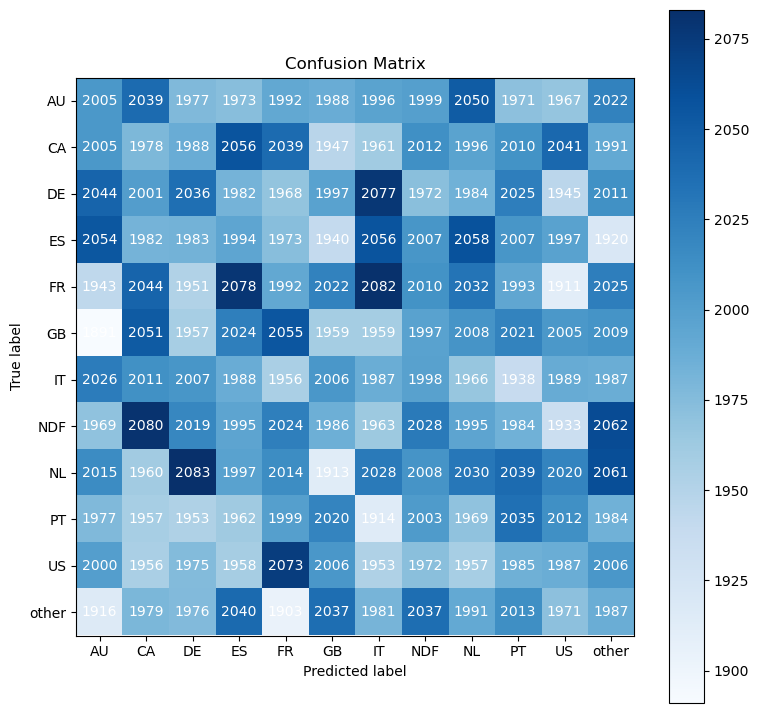

In [160]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification report
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(9,9))

- Accuracy: 8.3%.
- Balanced Accuracy: 8.3%. This metric is more realistic than accuracy since we have an imbalanced dataset.
- Kappa Score is too little. 

## 8.4. Neural Network - MLP

Firstly, we need to encode the response variable to work with neural network:

In [161]:
y_train

998636        IT
1357555    other
563618        ES
965050        IT
1245369       PT
           ...  
1331134    other
599350        ES
655237        ES
370219        CA
10967         US
Name: country_destination, Length: 1150176, dtype: object

In [162]:
# instantiate encoder
ohe = pp.OneHotEncoder()

# y train for neural network
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [163]:
y_train_nn

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [164]:
# MUST: number of neurons in the first layer must be higher than this value 
# Use the next higher number that is multiple of two: 2^2, 2^3, 2^4, etc. 
x_train.shape[1]

40

In [165]:
# MUST: number of neurons in the last layer = number of classes = number of transformed y columns
y_train_nn.shape[1]

12

Artifical Neural Network (ANN) - Multi-Layer Perceptron (MLP)

- We used softmax in the final layer because this one is good when the response variable is categorical. 
- Accuracy is the main metric to evaluate a classification model.
- See the image below to know the types of activation function to use. 
- Single Label: our problem is single label because an user can only choose one destination. If an user would choose two or more destinies, this problem would be multiple label. 
- Epochs: number of times we want the neural network train our model.

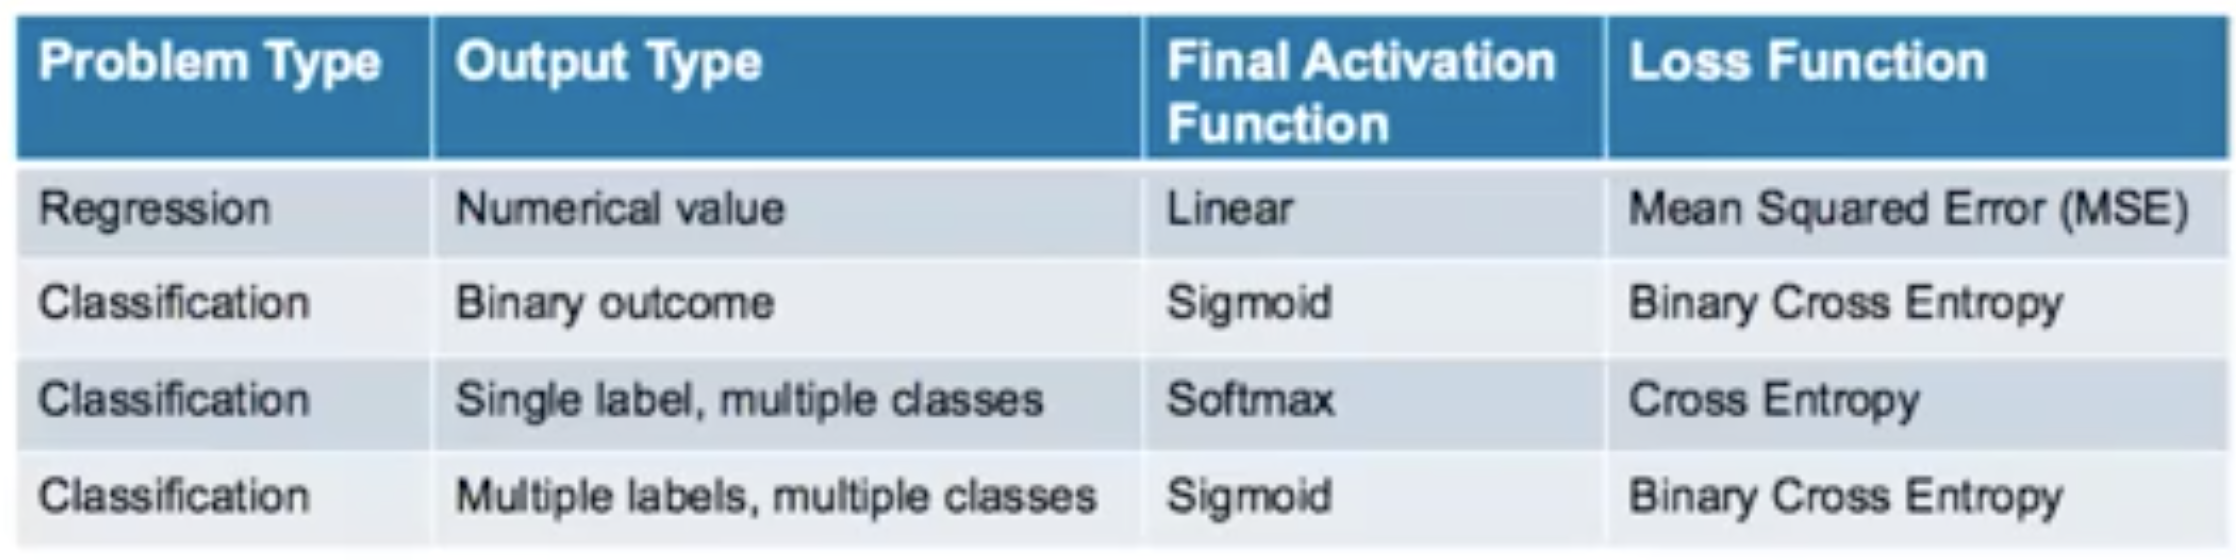

In [168]:
Image("images/ActivationFunctions.png")

In [169]:
 # model definition
model = ml.Sequential()

# hidden (64) and first layer (x_train.shape[1])
model.add(l.Dense(64, input_dim=x_train.shape[1], activation='relu'))

# last layer
model.add(l.Dense(12, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(x_train, y_train_nn, epochs=100)

Epoch 1/100
35943/35943 [==============================] - 30s 808us/step - loss: 2.0479 - accuracy: 0.2701
Epoch 2/100
35943/35943 [==============================] - 33s 906us/step - loss: 1.9516 - accuracy: 0.3007
Epoch 3/100
35943/35943 [==============================] - 30s 844us/step - loss: 1.9184 - accuracy: 0.3102
Epoch 4/100
35943/35943 [==============================] - 32s 890us/step - loss: 1.9030 - accuracy: 0.3141
Epoch 5/100
35943/35943 [==============================] - 31s 876us/step - loss: 1.8938 - accuracy: 0.3166
Epoch 6/100
35943/35943 [==============================] - 31s 849us/step - loss: 1.8880 - accuracy: 0.3170
Epoch 7/100
35943/35943 [==============================] - 30s 838us/step - loss: 1.8844 - accuracy: 0.3175
Epoch 8/100
35943/35943 [==============================] - 30s 829us/step - loss: 1.8813 - accuracy: 0.3183
Epoch 9/100
35943/35943 [==============================] - 30s 824us/step - loss: 1.8794 - accuracy: 0.3185
Epoch 10/100
35943/35943 [==

35943/35943 [==============================] - 35s 967us/step - loss: 1.8499 - accuracy: 0.3278
Epoch 77/100
35943/35943 [==============================] - 35s 960us/step - loss: 1.8497 - accuracy: 0.3281
Epoch 78/100
35943/35943 [==============================] - 30s 838us/step - loss: 1.8496 - accuracy: 0.3279
Epoch 79/100
35943/35943 [==============================] - 29s 812us/step - loss: 1.8495 - accuracy: 0.3276
Epoch 80/100
35943/35943 [==============================] - 30s 841us/step - loss: 1.8492 - accuracy: 0.3281
Epoch 81/100
35943/35943 [==============================] - 33s 916us/step - loss: 1.8492 - accuracy: 0.3277
Epoch 82/100
35943/35943 [==============================] - 34s 942us/step - loss: 1.8490 - accuracy: 0.3280
Epoch 83/100
35943/35943 [==============================] - 37s 1ms/step - loss: 1.8490 - accuracy: 0.3277
Epoch 84/100
35943/35943 [==============================] - 35s 977us/step - loss: 1.8488 - accuracy: 0.3282
Epoch 85/100
35943/35943 [========

### 8.4.1. NN Single Performance

In [170]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction - going back to the categorical attributes 
# real prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

8986/8986 [==============================] - 6s 610us/step


Accuracy: 0.324079097459867
Balanced Accuracy: 0.32420555734202305
Kappa Score: 0.26259639606720386
              precision    recall  f1-score   support

          AU       0.29      0.75      0.42     23979
          CA       0.17      0.21      0.19     24024
          DE       0.19      0.20      0.20     24042
          ES       0.14      0.17      0.16     23971
          FR       0.14      0.13      0.13     24083
          GB       0.14      0.06      0.08     23936
          IT       0.14      0.08      0.10     23859
         NDF       1.00      1.00      1.00     24038
          NL       0.20      0.15      0.17     24168
          PT       0.85      0.97      0.91     23785
          US       0.15      0.12      0.13     23828
       other       0.15      0.04      0.07     23831

    accuracy                           0.32    287544
   macro avg       0.30      0.32      0.30    287544
weighted avg       0.30      0.32      0.30    287544



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

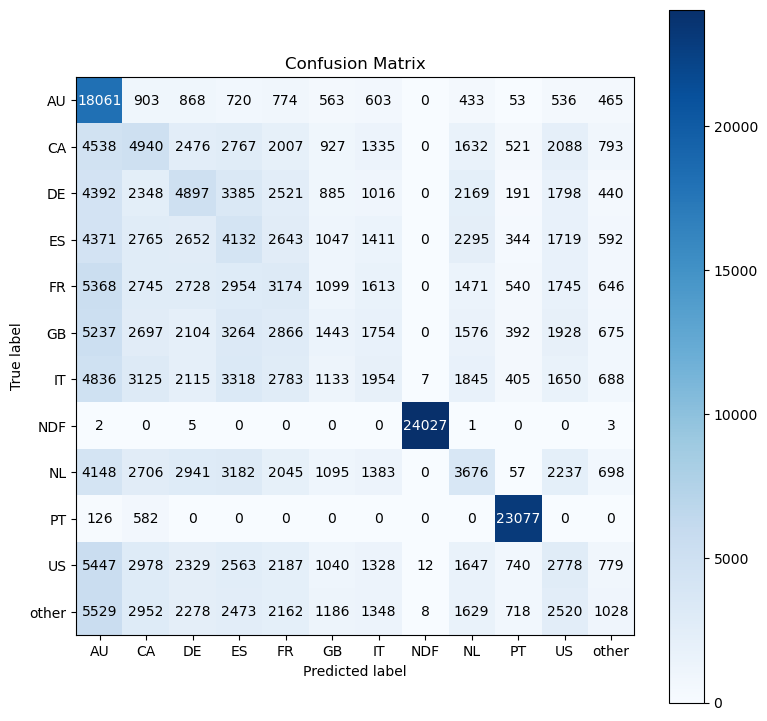

In [171]:
# Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuray
balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification report
print(m.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(9,9))

- Accuracy of 88% is a good one, but... 
- The model chose US even when the true class was other countries.
- The neural network is biased towards the class with more available examples: US.


- The majority of predictions for US were correct. For true US, the wrong predictions were: CA (1), DE (5), ES (1), FR (7), GB (4) and IT (2). 
- AU: accuracy = 0%. CA: accuracy = 0%. All predictions for AU and CA were wrong.

Accuracy basically is: how much right predictions I have chose correctly over the amount of predictions I did. 

- Balanced Accuracy of 17% is much more realistic. We want to increase it to values around 85%.
- Kappa Score is 77%. We want values higher than 70%.

### 8.4.2. NN Cross-Validation Performance

#### Theory

We may understand **selection bias** as the bias with the following characteristics:

1. The luck of selecting a good training dateset. 
2. Some behaviors may be hidden in datasets which were not selected.
3. Different behaviors for training and test datasets. 

- We must avoid selection bias because we want our model learns the most from the data patterns. In order to minimize this bias, we are going to split out data into several training and test datasets. This technique is named Cross-Validation. 

- The split is made randomly for a classification problem. However, when we work with time series, this sampling must not be random, since the time is very important to this type of problem.

- Cross-Validation is not very good for imbalanced/unbalanced data, since we have majority classes and probably the majority class will be chosen more times through random sampling.

#### Practice

- **kfold.split()** keeps the proportion of classes.
- **train_ix:** index of training dataset.
- **val_ix:** index of validation ("test") dataset.

In [ ]:
 # generate k-fold
num_folds = 5 # shuffle = True: the split is done randomly
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    print( 'Fold Number: {}/{}'.format(i, num_folds))
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()

    # model definition
    model = ml.Sequential()
    model.add(l.Dense(128, input_dim=x_train.shape[1], activation='relu'))
    model.add(l.Dense(12, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # training model
    model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)

    # prediction
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn)
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
    
    i += 1

In [ ]:
pd.DataFrame( {'Average Balanced Accuracy': np.round( np.mean( balanced_acc_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( balanced_acc_list  ), 4 ).astype( str ),
                'Average Kappa': np.round( np.mean( kappa_acc_list ), 4 ).astype( str ) + ' +/- ' + np.round( np.std( kappa_acc_list ), 4 ).astype( str ) }, index=[0] )
